In [1]:
import pandas as pd
from copy import deepcopy
import numpy as np

In [2]:
barcodes = pd.read_csv('https://raw.githubusercontent.com/juliendelile/MouseSpinalCordAtlas/master/output/phenoData_annotated.csv', sep = '\t', index_col = 0)
selected_genes = pd.read_csv('/Users/sophielohshvits/Desktop/selected_genes.csv', sep = ',', index_col = 0)

In [3]:
subtypes_by_barcodes = barcodes[['Neuron_subtypes', 'Type_step2_unique']]
subtypes_by_barcodes = subtypes_by_barcodes.apply(lambda x: x['Type_step2_unique'] if pd.isna(x['Neuron_subtypes']) else 
                                   x['Neuron_subtypes'], axis=1)
subtypes_by_barcodes[subtypes_by_barcodes.isna()] = 'Not_Defined'
subtypes_by_barcodes
barcodes['final_step'] = subtypes_by_barcodes
barcodes

,timepoint,replicate_id,Type_step1,Type_step2,Type_step2_unique,DV,Neuron_subtypes,Pseudotime,final_step
AAACCTGAGCAGACTG-1,9.5,1,Mesoderm V,NaN,Mesoderm V,NaN,NaN,NaN,Mesoderm V
AAACCTGCAAGCGAGT-1,9.5,1,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
AAACCTGGTCCCTACT-1,9.5,1,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
AAACCTGTCAGCACAT-1,9.5,1,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
AAACCTGTCCCTTGCA-1,9.5,1,Mesoderm V,NaN,Mesoderm V,NaN,NaN,NaN,Mesoderm V
...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTATGCT-11,13.5,3,Neuron,dl2,dl2,11.0,dl2.1,95.128997,dl2.1
TTTGTCAGTAGCTAAA-11,13.5,3,Neuron,dl4,dl4.1,9.0,dl4.6,83.166268,dl4.6
TTTGTCATCAGGTTCA-11,13.5,3,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
TTTGTCATCGGAATCT-11,13.5,3,Neuron,Null_Neuron,Null_Neuron,NaN,NaN,NaN,Null_Neuron


In [4]:
# log2_ts_tp возвращает таблицу с не нормированными каунтами от timepoint, типа клеток type_step

def counts_ts_tp(type_step, timepoint): 
    
    barcodes_tp = barcodes[barcodes["timepoint"] == timepoint]
    
    selected_genes_tp = selected_genes[barcodes_tp.loc[~barcodes_tp[type_step].isna()].index]
    barcodes_tp = barcodes_tp.loc[~barcodes_tp[type_step].isna()]
    
    subtypes_by_barcodes = barcodes_tp[type_step]
    
    genes_renamed_columns = deepcopy(selected_genes_tp)
    new_cols = {key: value for key, value in zip(genes_renamed_columns.columns.values, subtypes_by_barcodes.values)}
    genes_renamed_columns.rename(columns = new_cols, inplace=True)
    genes_cell_types_counts = genes_renamed_columns.groupby(lambda x: x, axis=1).sum()

    depth = pd.read_csv('https://raw.githubusercontent.com/eentartetekunst/latrophilines/main/depth.tsv', sep = '\t', index_col = 0)
    depth = depth.loc[subtypes_by_barcodes.index]
    depth = depth.T
    
    depth_cols = {key: value for key, value in zip(depth.columns.values, subtypes_by_barcodes.values)}
    depth.rename(columns = depth_cols, inplace=True)
    celltypes_depth = depth.groupby(lambda x: x, axis=1).sum()
    
    celltypes_norm = genes_cell_types_counts.div(celltypes_depth.values, axis=1) * 1e6
    
    log_celltypes_norm = celltypes_norm.apply(lambda x: x + 1, axis=1)
    log_celltypes_norm = np.log2(log_celltypes_norm)

    log_celltypes_norm = log_celltypes_norm.rename(index={"ENSMUSG00000013033":'ADGRL1',"ENSMUSG00000028184": 'ADGRL2',"ENSMUSG00000037605": 'ADGRL3',"ENSMUSG00000016150": 'TENM1',"ENSMUSG00000049336": 'TENM2',"ENSMUSG00000031561": 'TENM3',"ENSMUSG00000048078": 'TENM4',"ENSMUSG00000047787": 'FLRT1',"ENSMUSG00000047414": 'FLRT2',"ENSMUSG00000051379": 'FLRT3',"ENSMUSG00000024109": 'NRXN1'})


    return log_celltypes_norm

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [48]:
def heatmap(data, timepoints, type_step_x):
    
    sns.set_palette('rocket_r')


    figure(figsize=(30,15))
    b = sns.heatmap(data.iloc[:, :], cmap="coolwarm")

    b.axes.set_title("day {}, {}".format(timepoints,type_step_x) ,fontsize=40)
    b.set_xlabel("Subtypes of cells",fontsize=25)
    b.set_ylabel("Genes",fontsize=25)
    b.tick_params(labelsize=25)
    plt.xticks(rotation=90)  
    plt.yticks(rotation=0)             
    plt.tight_layout()
    plt.savefig("heatmap_day_{}_{}.pdf".format(timepoints, type_step_x), dpi=1000)


    
    return b

In [49]:
def barplot(data, timepoints, type_step_x):
    
    sns.set_palette('rocket_r')
    
    figure(figsize=(30,15))
    a = sns.barplot(x=data.columns, y = data.loc['ADGRL1'], palette='coolwarm')

    a.axes.set_title("day {}, {}".format(timepoints, type_step_x) ,fontsize=40)
    a.set_xlabel("Subtypes of cells",fontsize=25)
    a.set_ylabel("ADGRL1 log2",fontsize=25)
    a.tick_params(labelsize=25)
    plt.xticks(rotation=90)             
    plt.yticks(rotation=0)             

    plt.tight_layout()
    plt.savefig("barplot_day_{}_{}.pdf".format(timepoints, type_step_x), dpi=1000)


    return a

In [50]:
barcodes

,timepoint,replicate_id,Type_step1,Type_step2,Type_step2_unique,DV,Neuron_subtypes,Pseudotime,final_step
AAACCTGAGCAGACTG-1,9.5,1,Mesoderm V,NaN,Mesoderm V,NaN,NaN,NaN,Mesoderm V
AAACCTGCAAGCGAGT-1,9.5,1,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
AAACCTGGTCCCTACT-1,9.5,1,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
AAACCTGTCAGCACAT-1,9.5,1,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
AAACCTGTCCCTTGCA-1,9.5,1,Mesoderm V,NaN,Mesoderm V,NaN,NaN,NaN,Mesoderm V
...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTATGCT-11,13.5,3,Neuron,dl2,dl2,11.0,dl2.1,95.128997,dl2.1
TTTGTCAGTAGCTAAA-11,13.5,3,Neuron,dl4,dl4.1,9.0,dl4.6,83.166268,dl4.6
TTTGTCATCAGGTTCA-11,13.5,3,NaN,NaN,NaN,NaN,NaN,NaN,Not_Defined
TTTGTCATCGGAATCT-11,13.5,3,Neuron,Null_Neuron,Null_Neuron,NaN,NaN,NaN,Null_Neuron


In [51]:
timepoints = set(barcodes['timepoint'].values)

In [52]:
columns = ["Type_step1", "Type_step2", 'final_step']

<ipython-input-49-4292939a2e64>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(30,15))


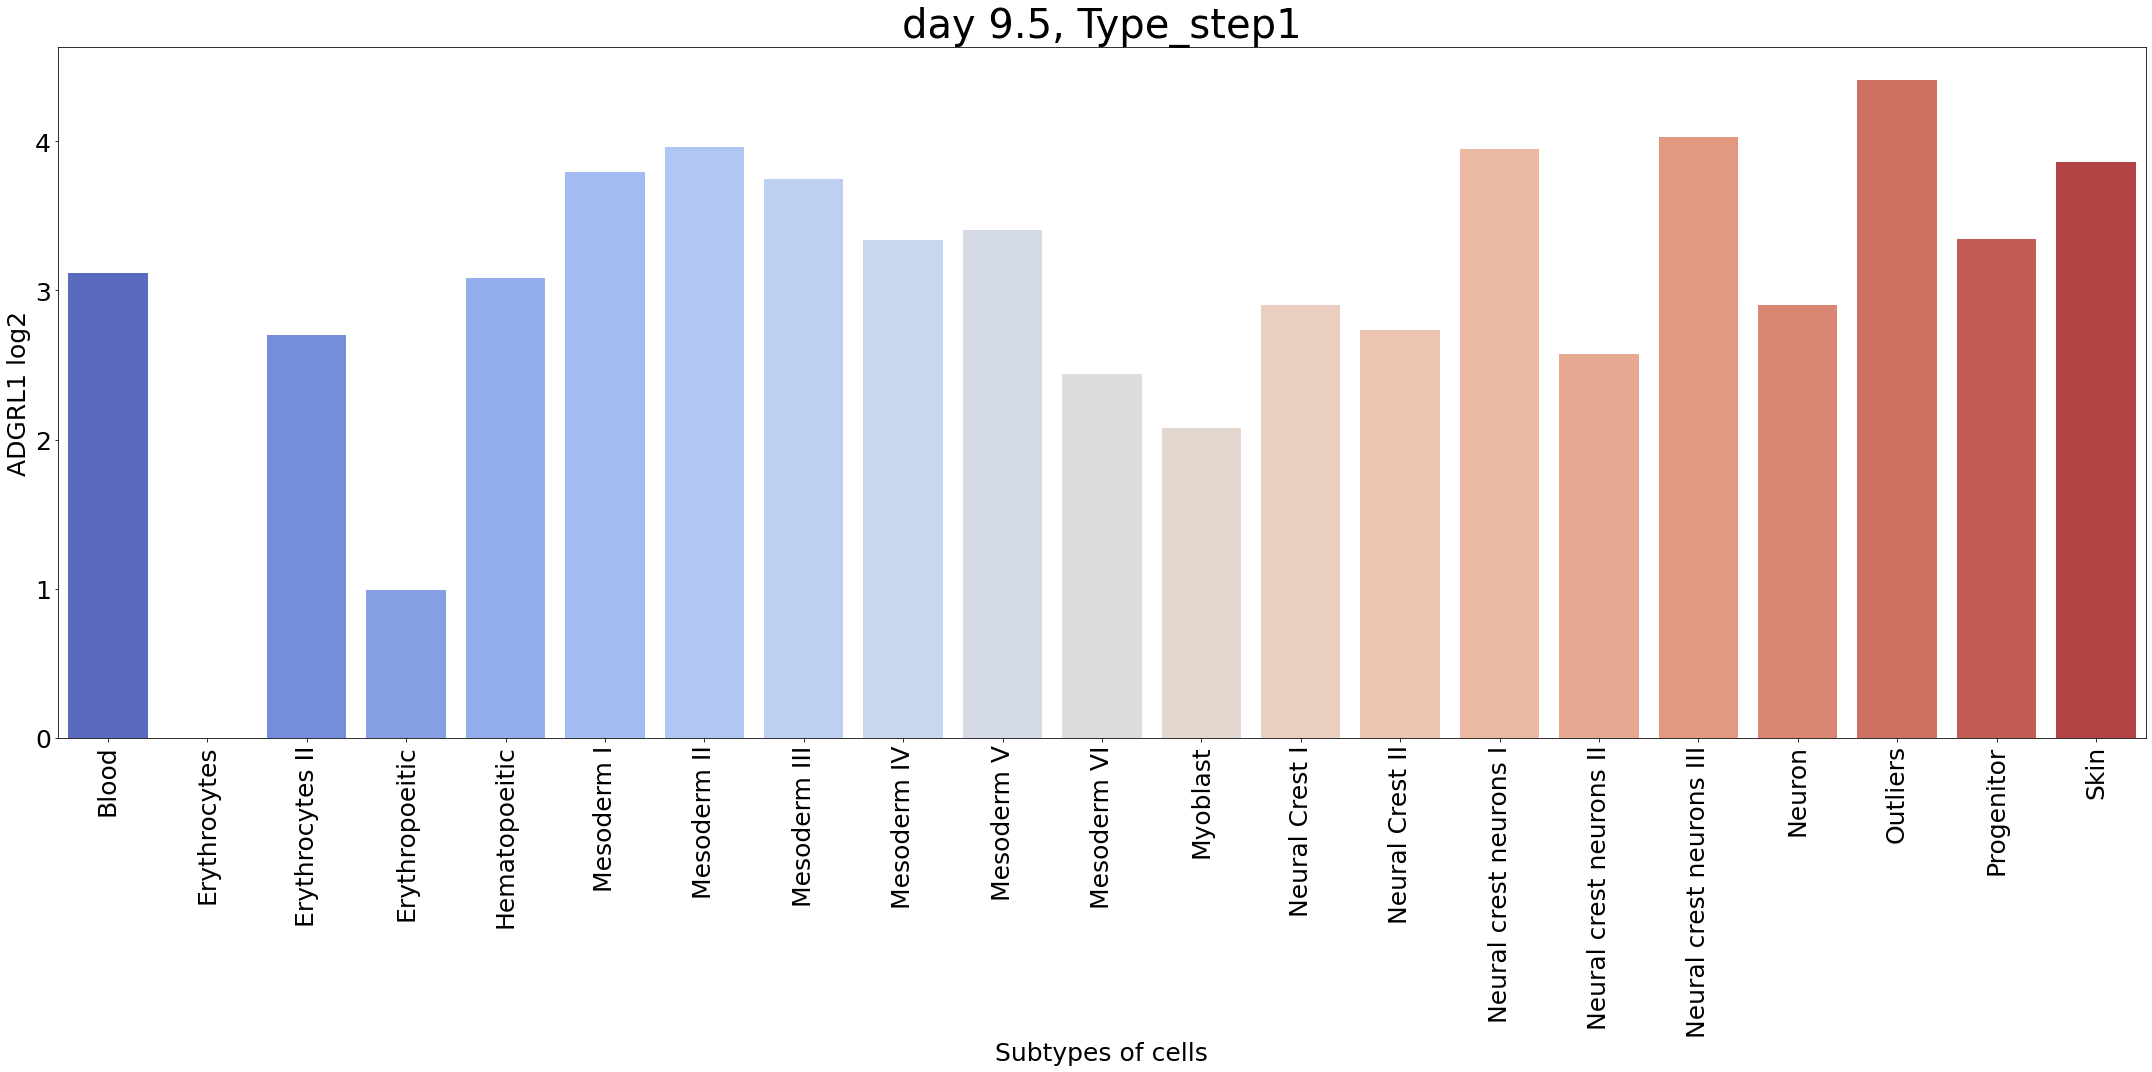

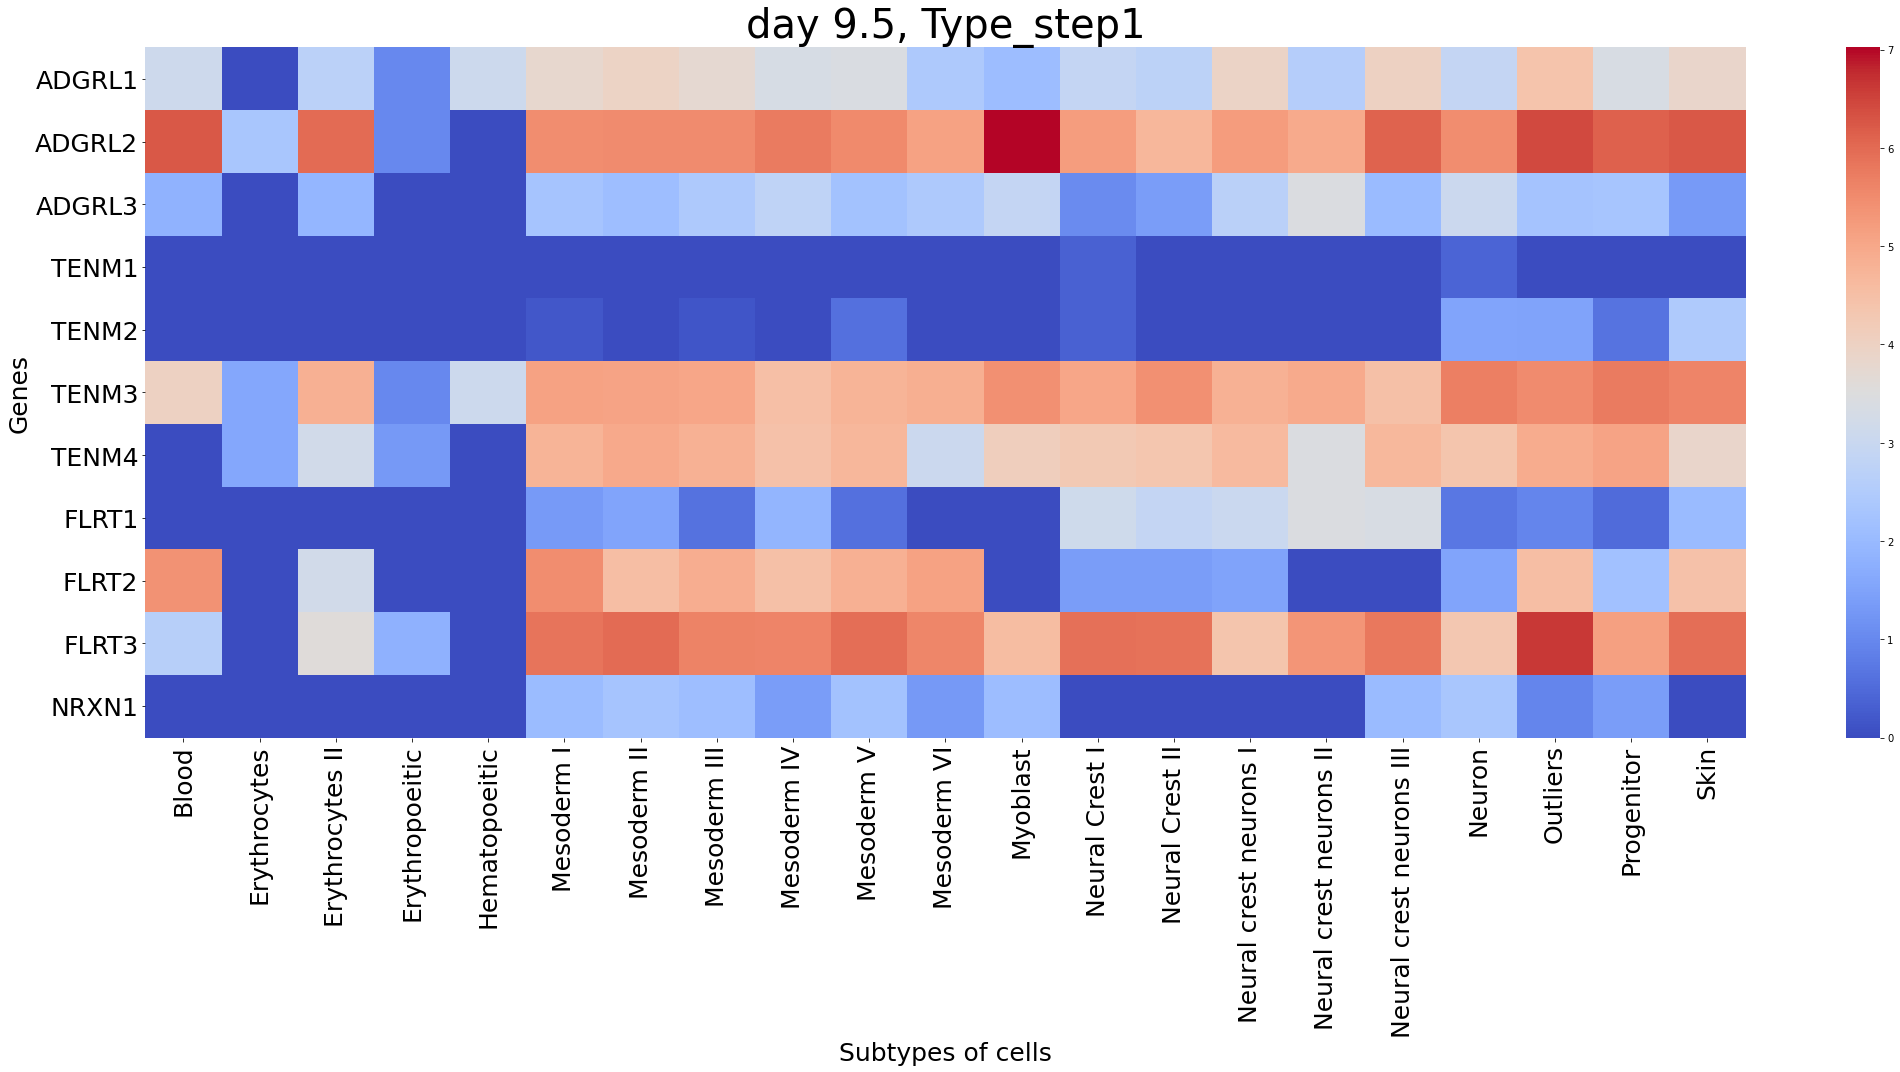

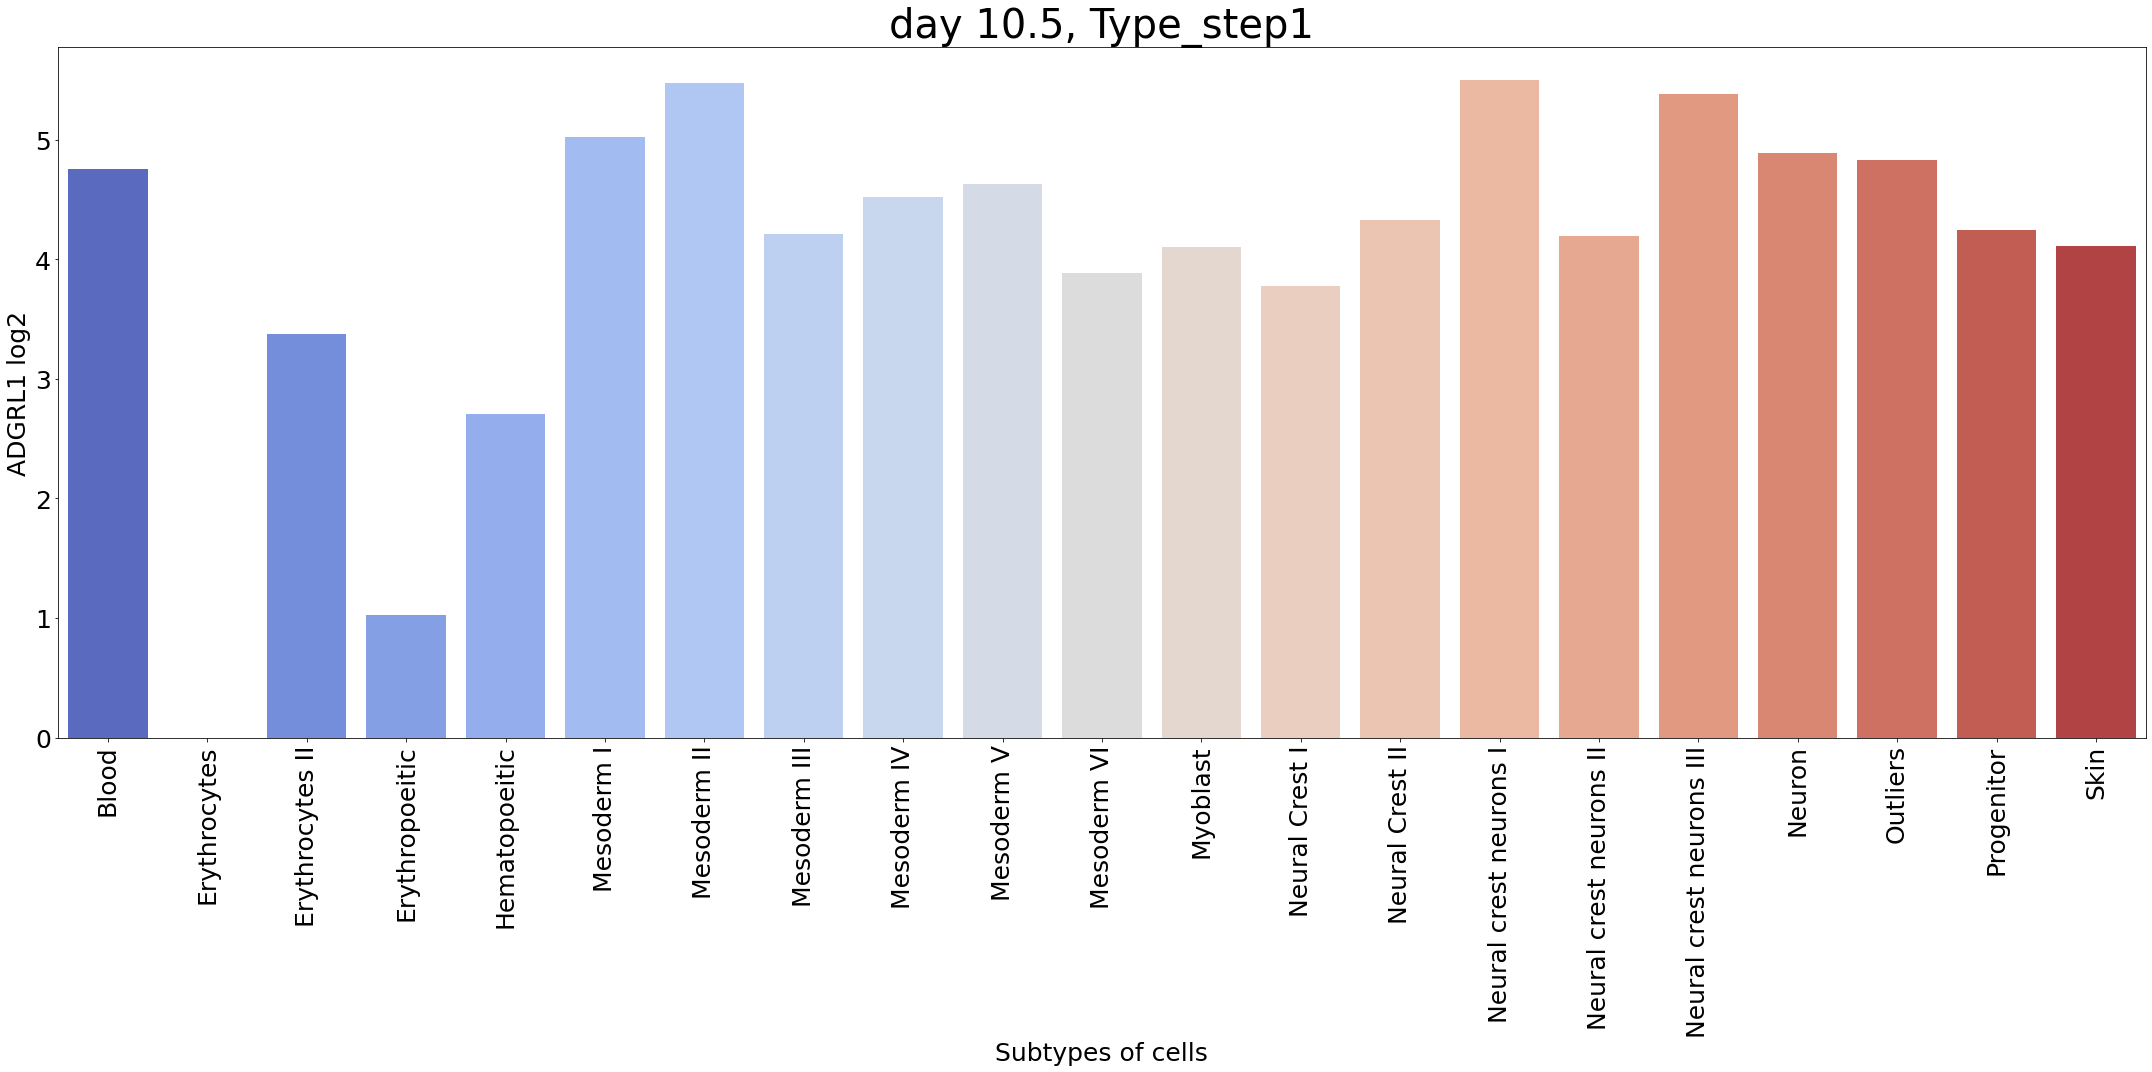

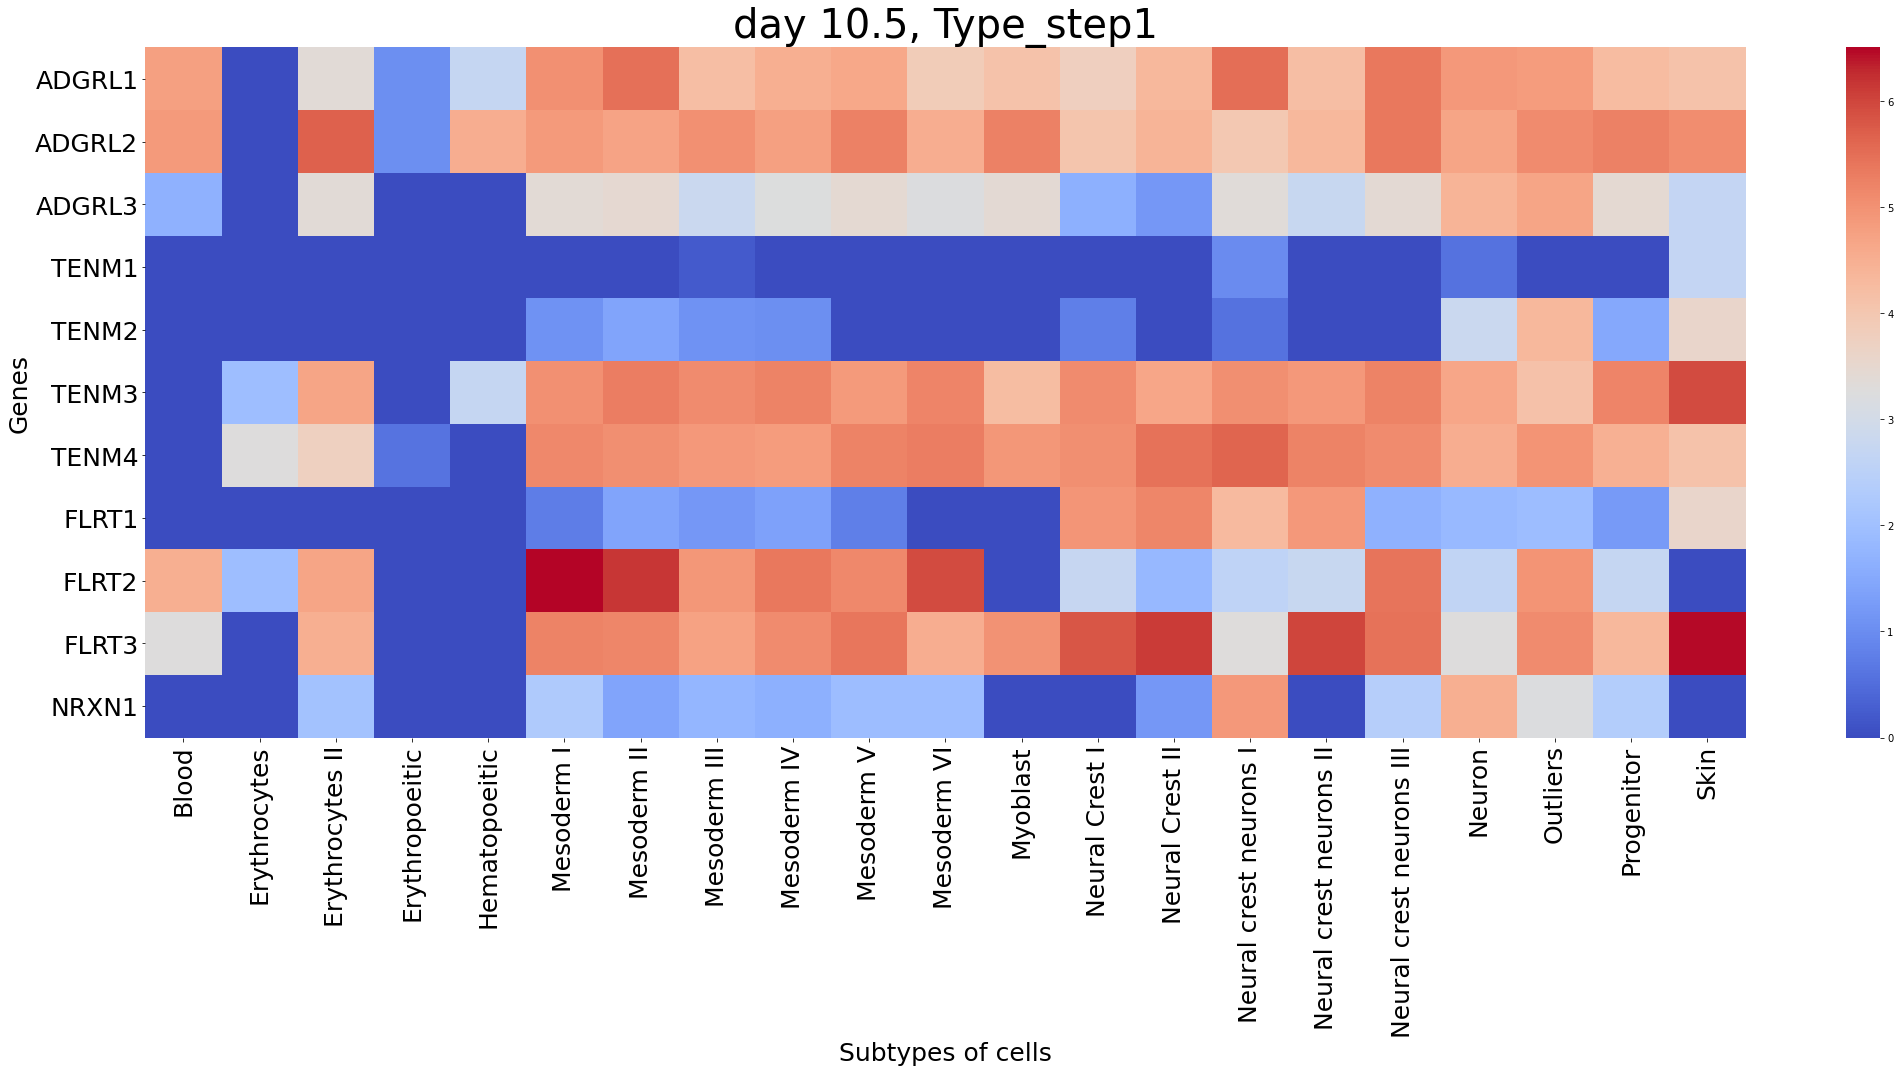

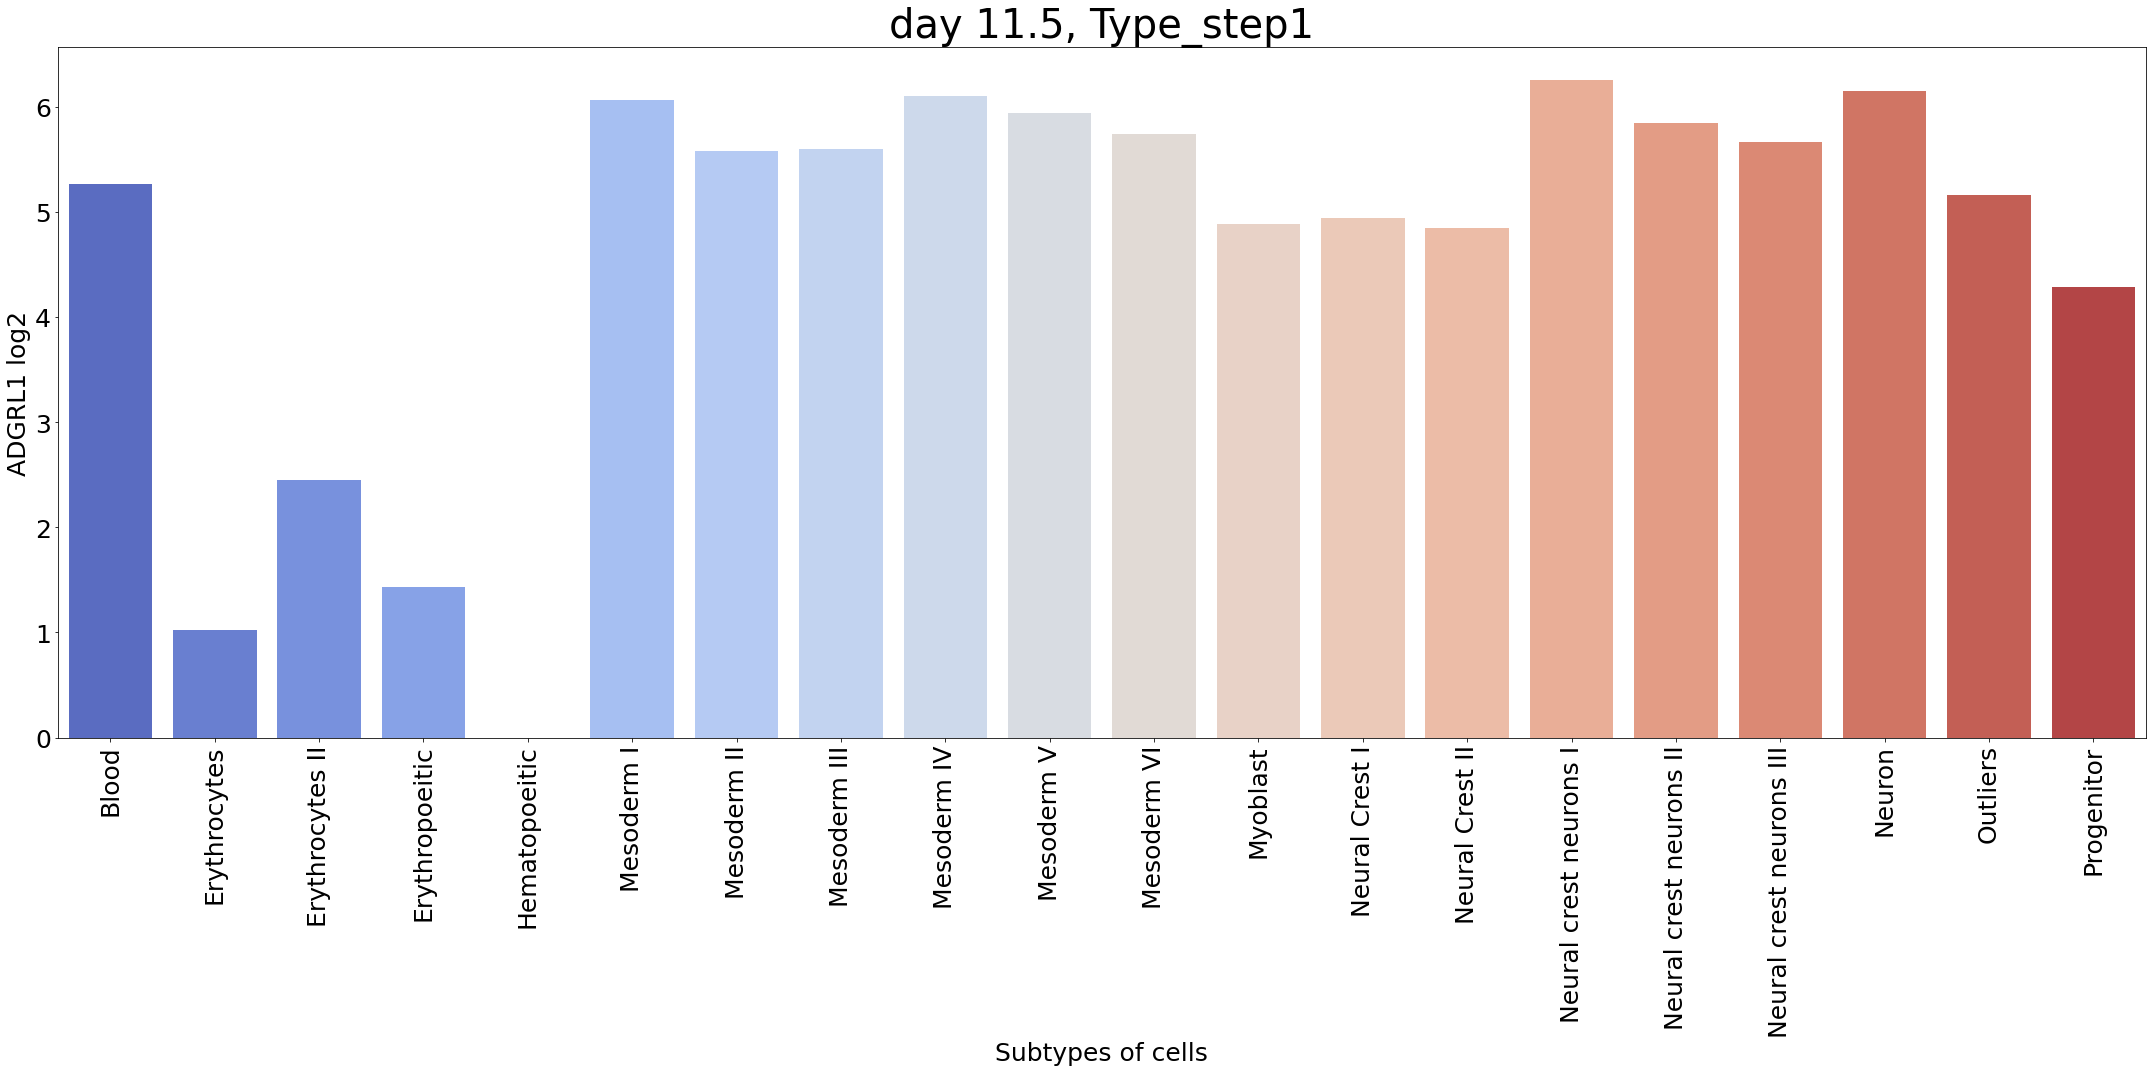

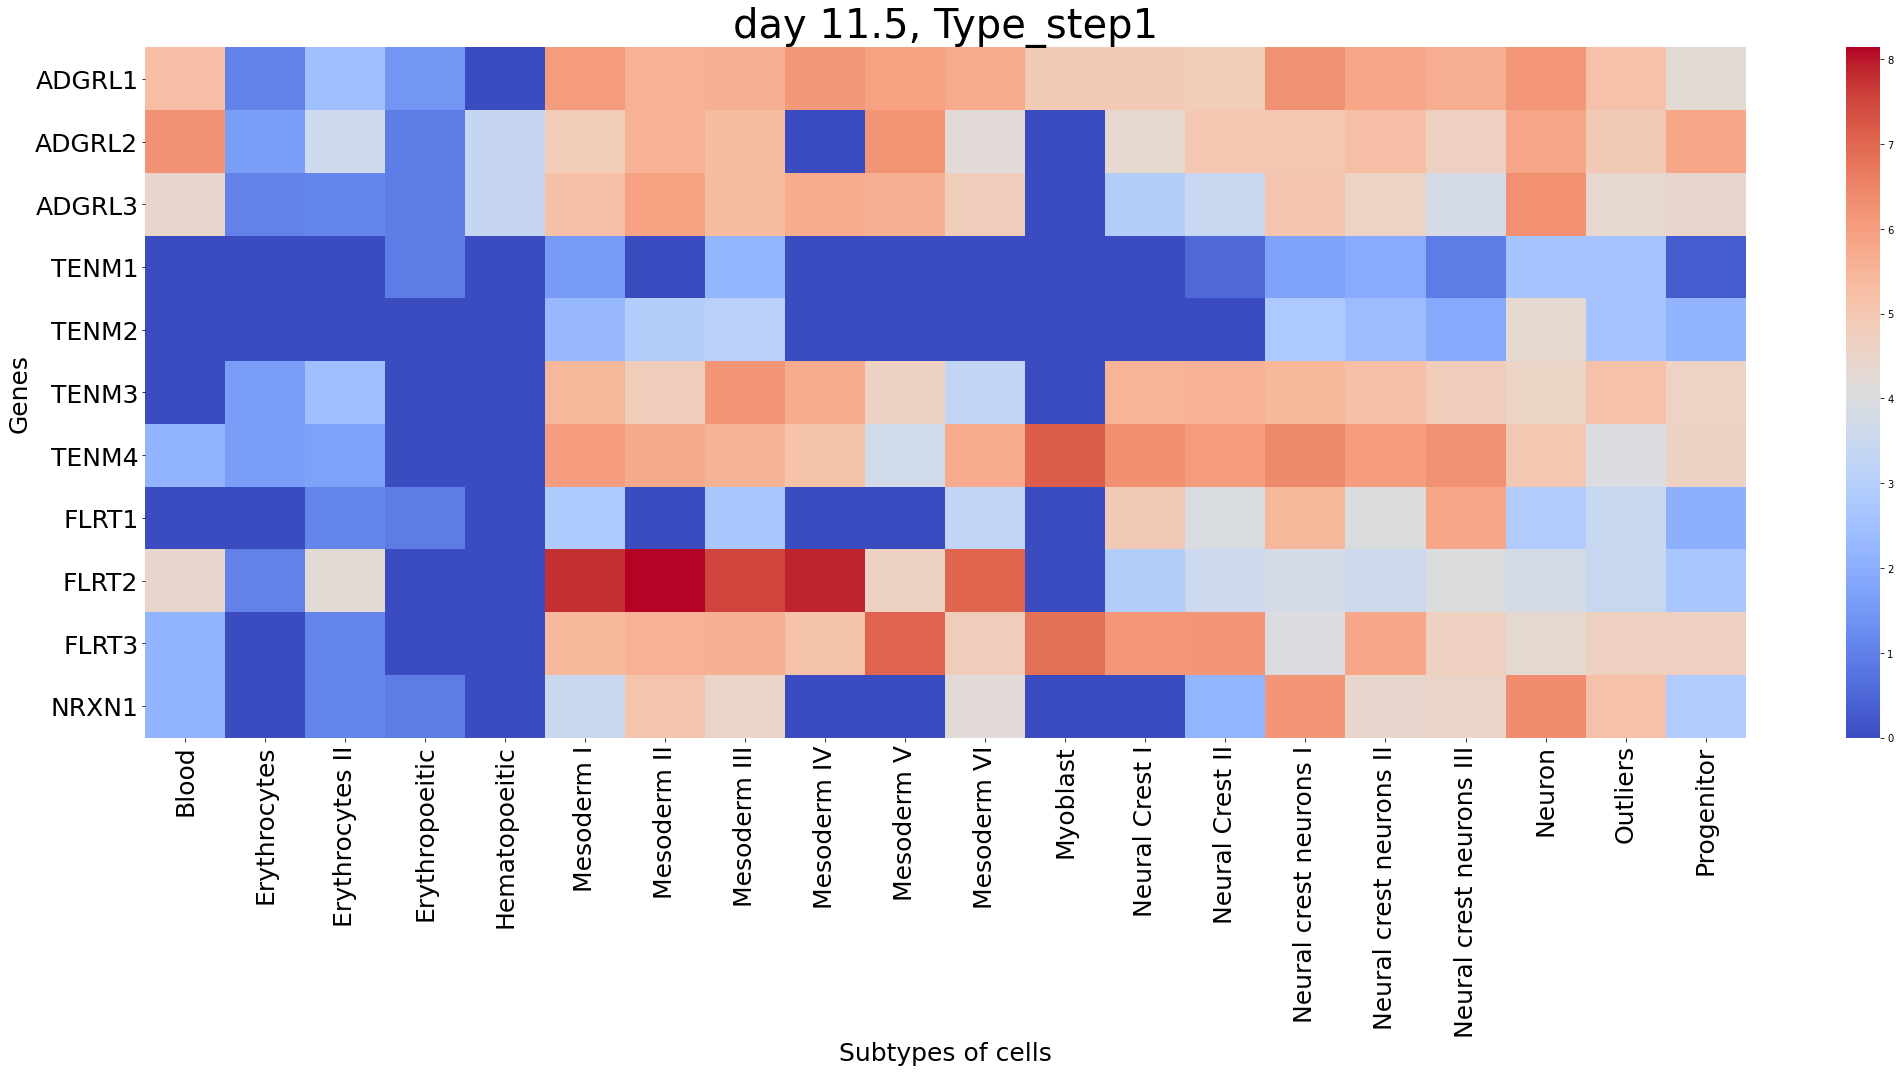

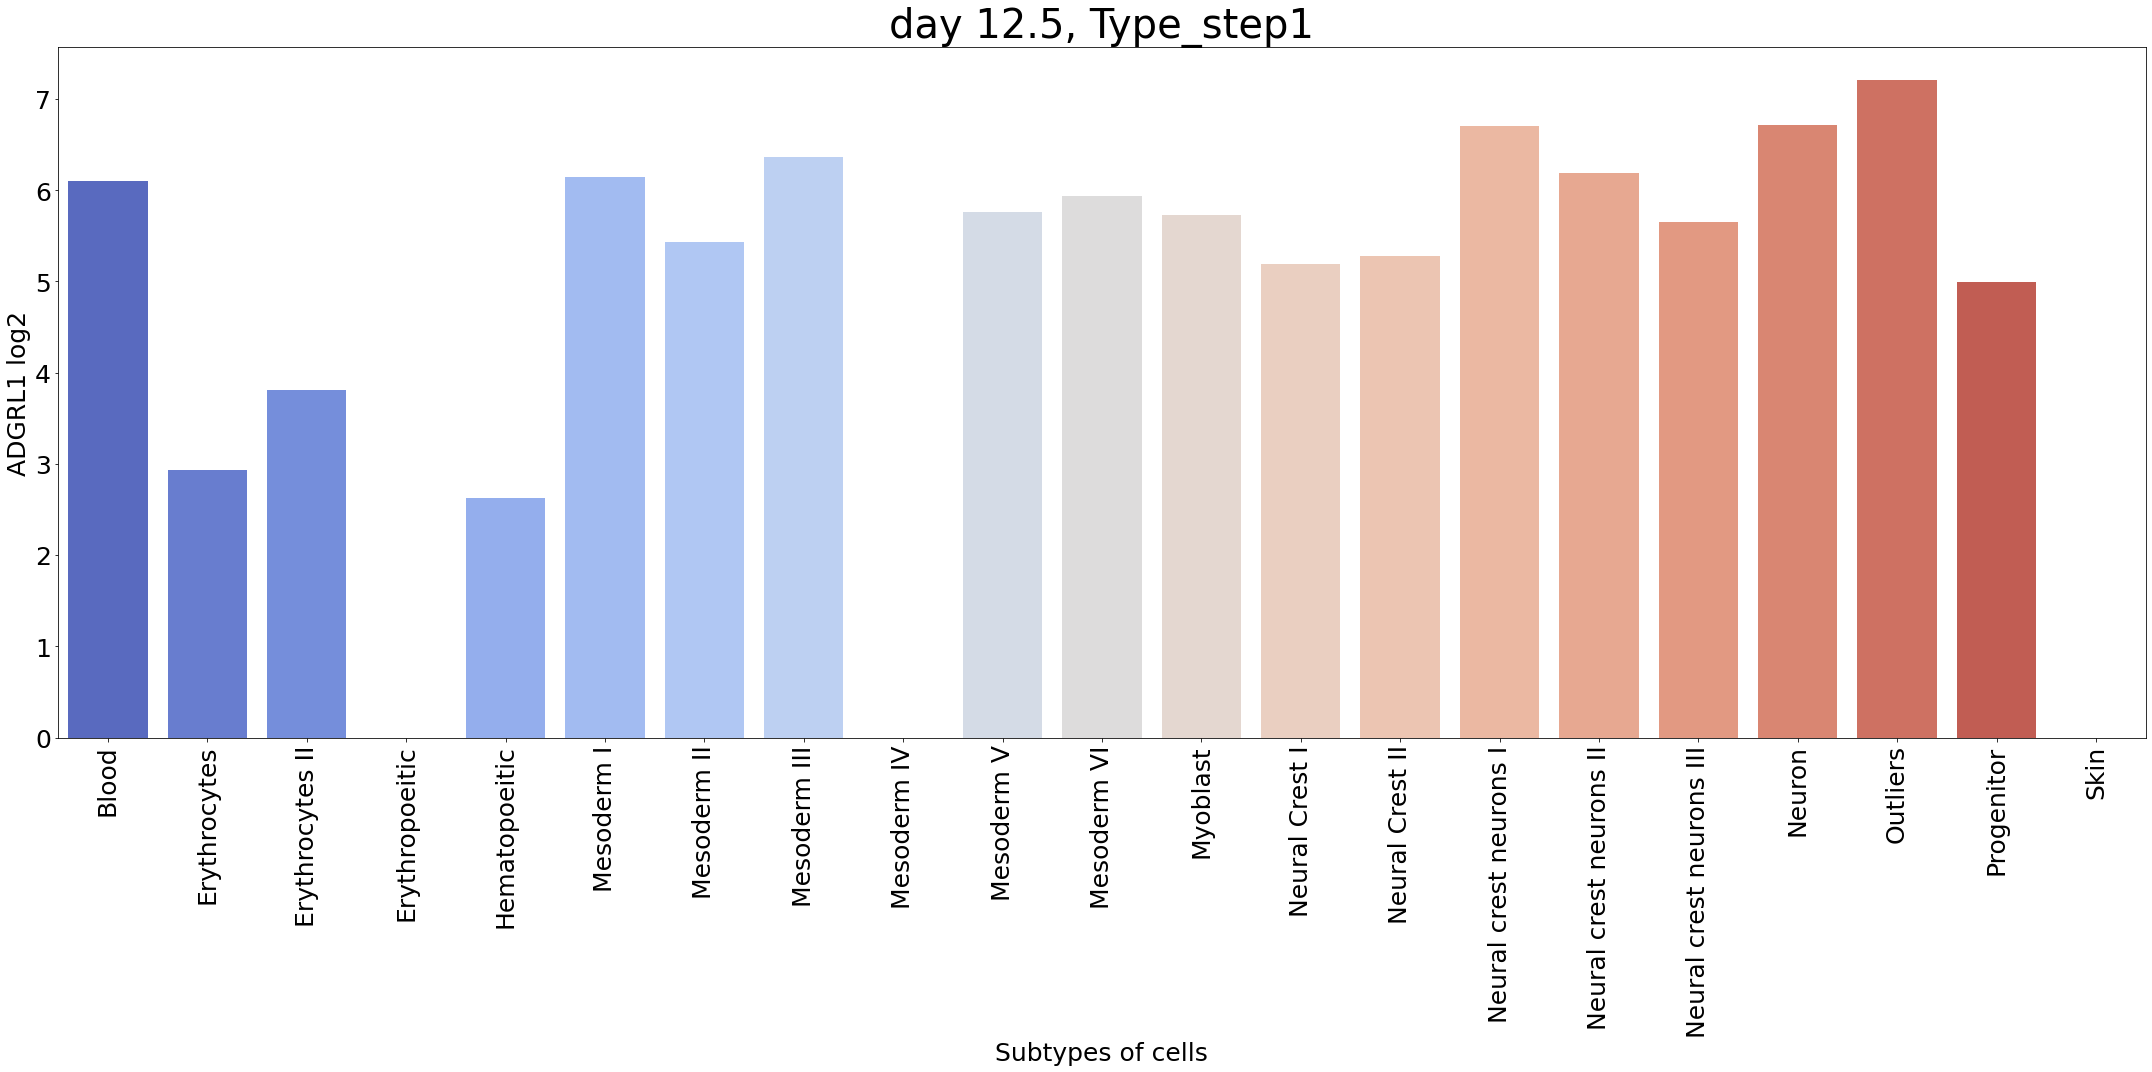

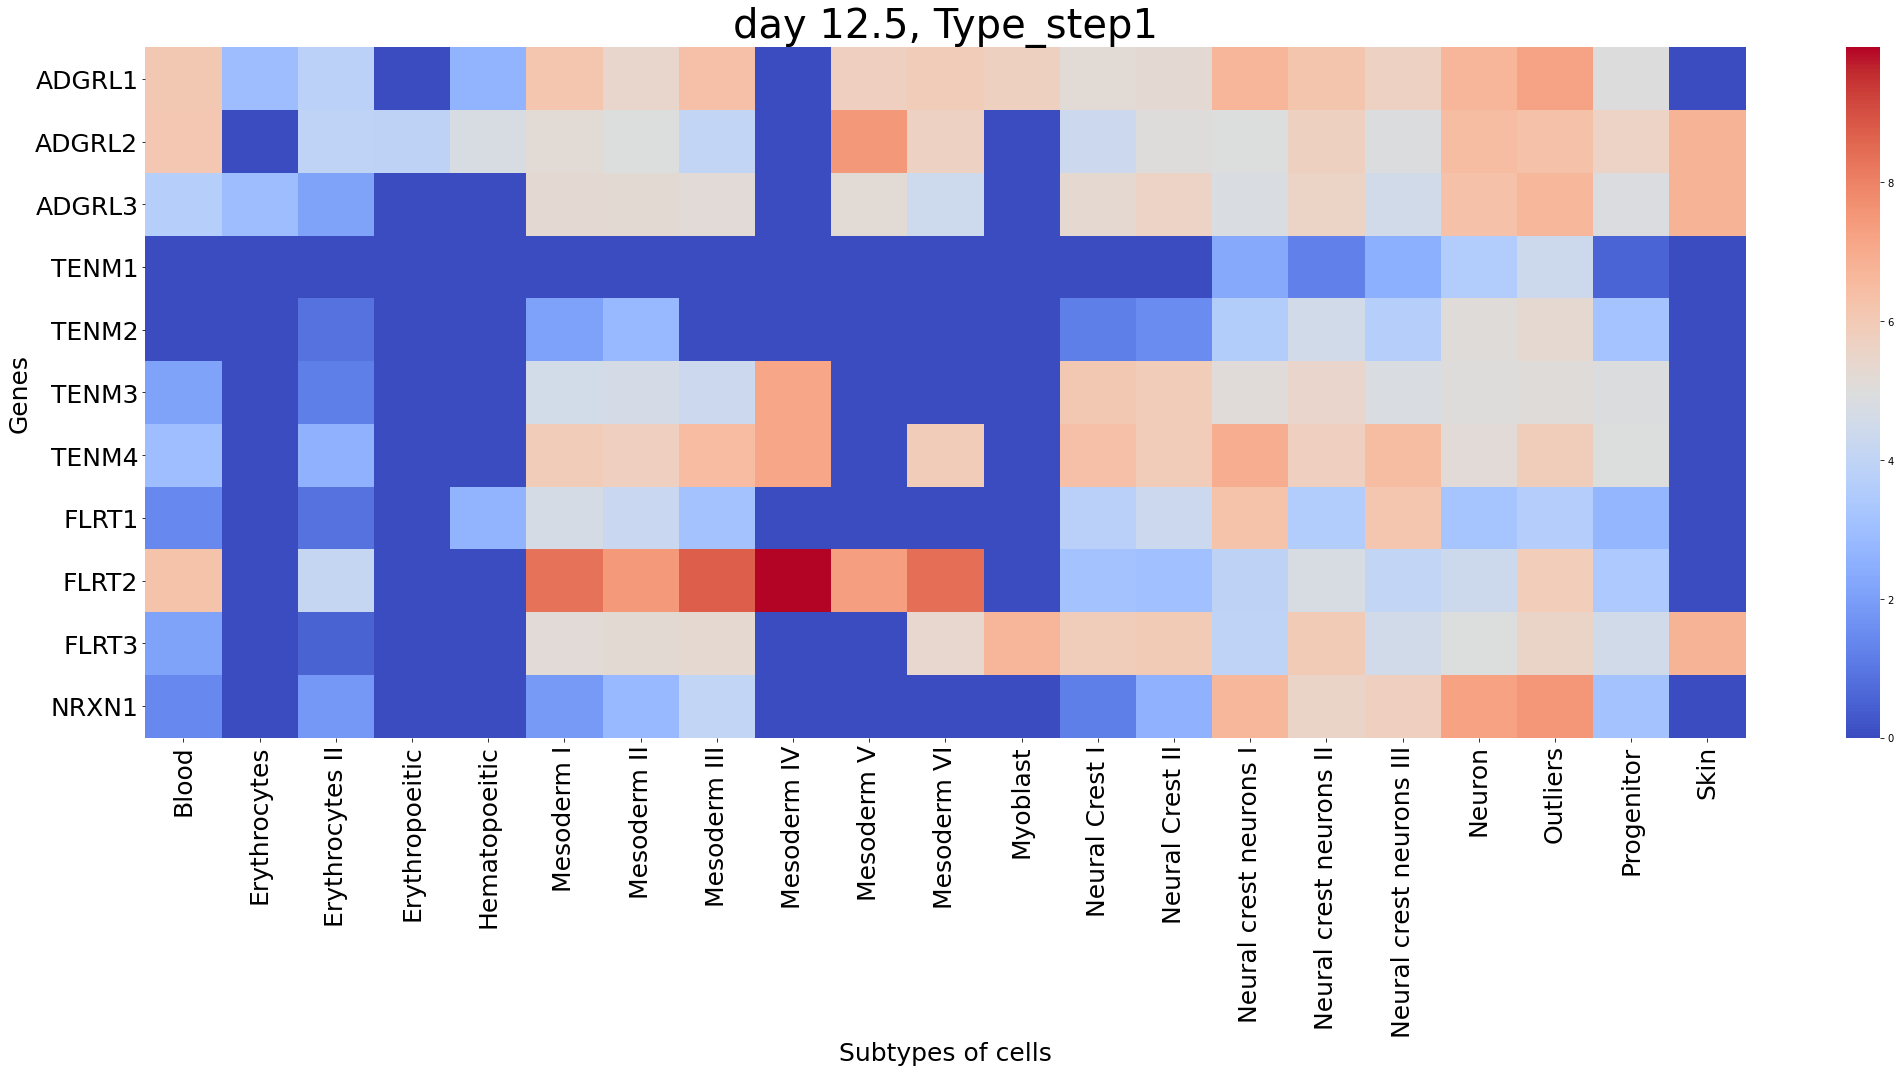

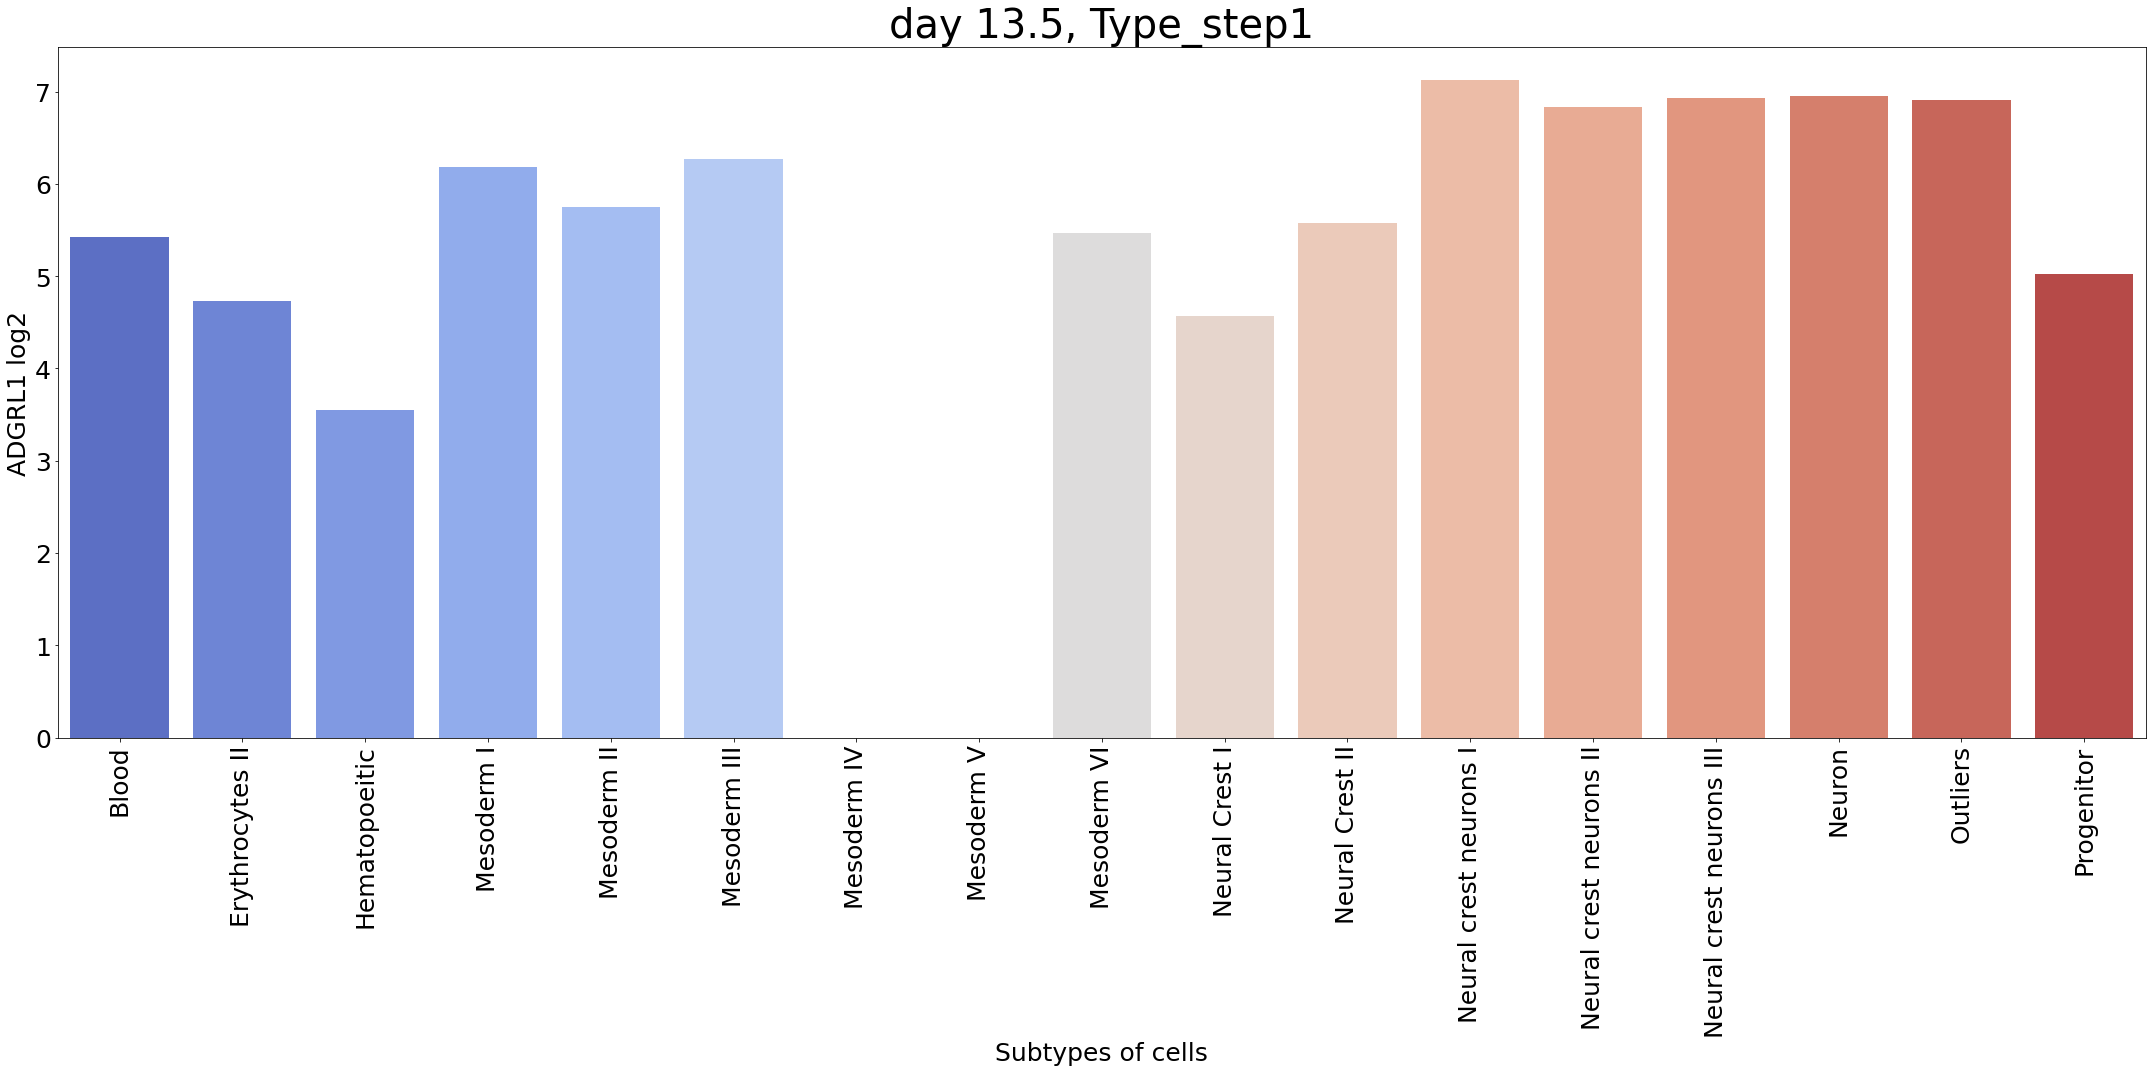

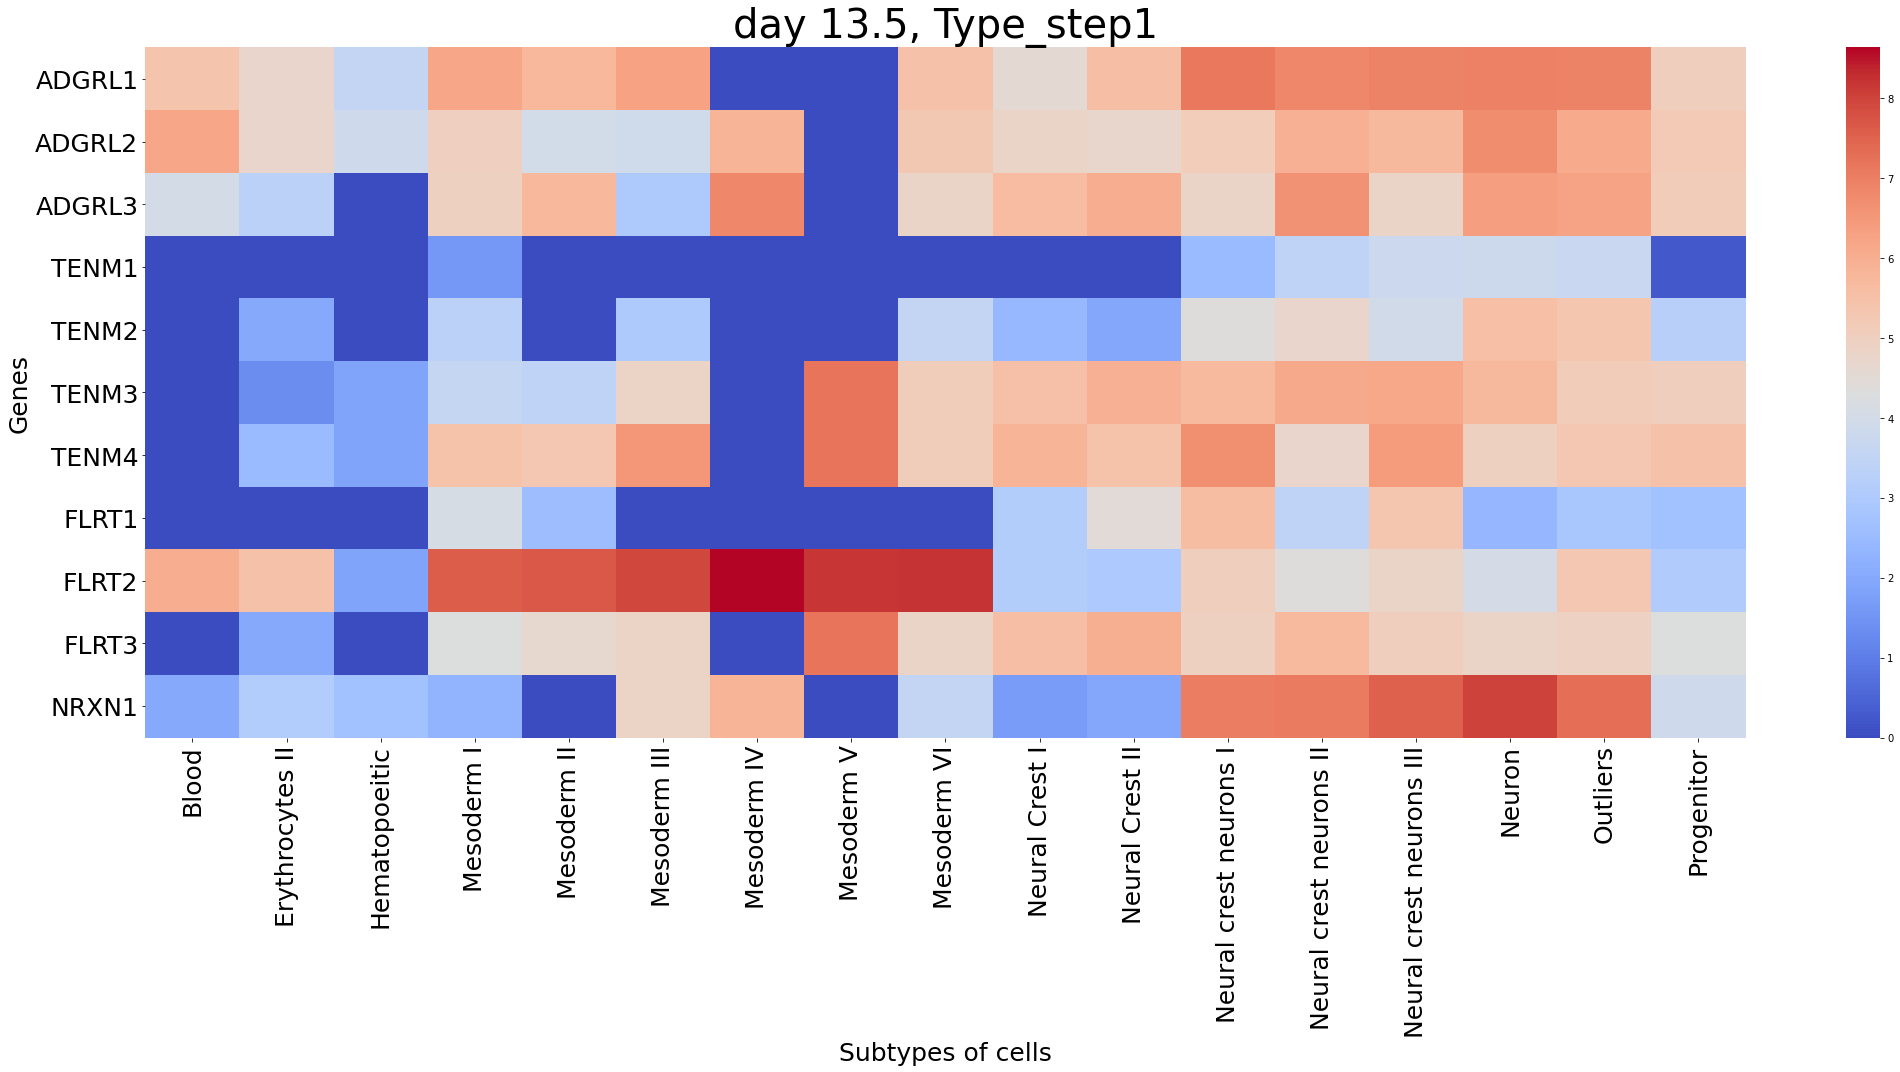

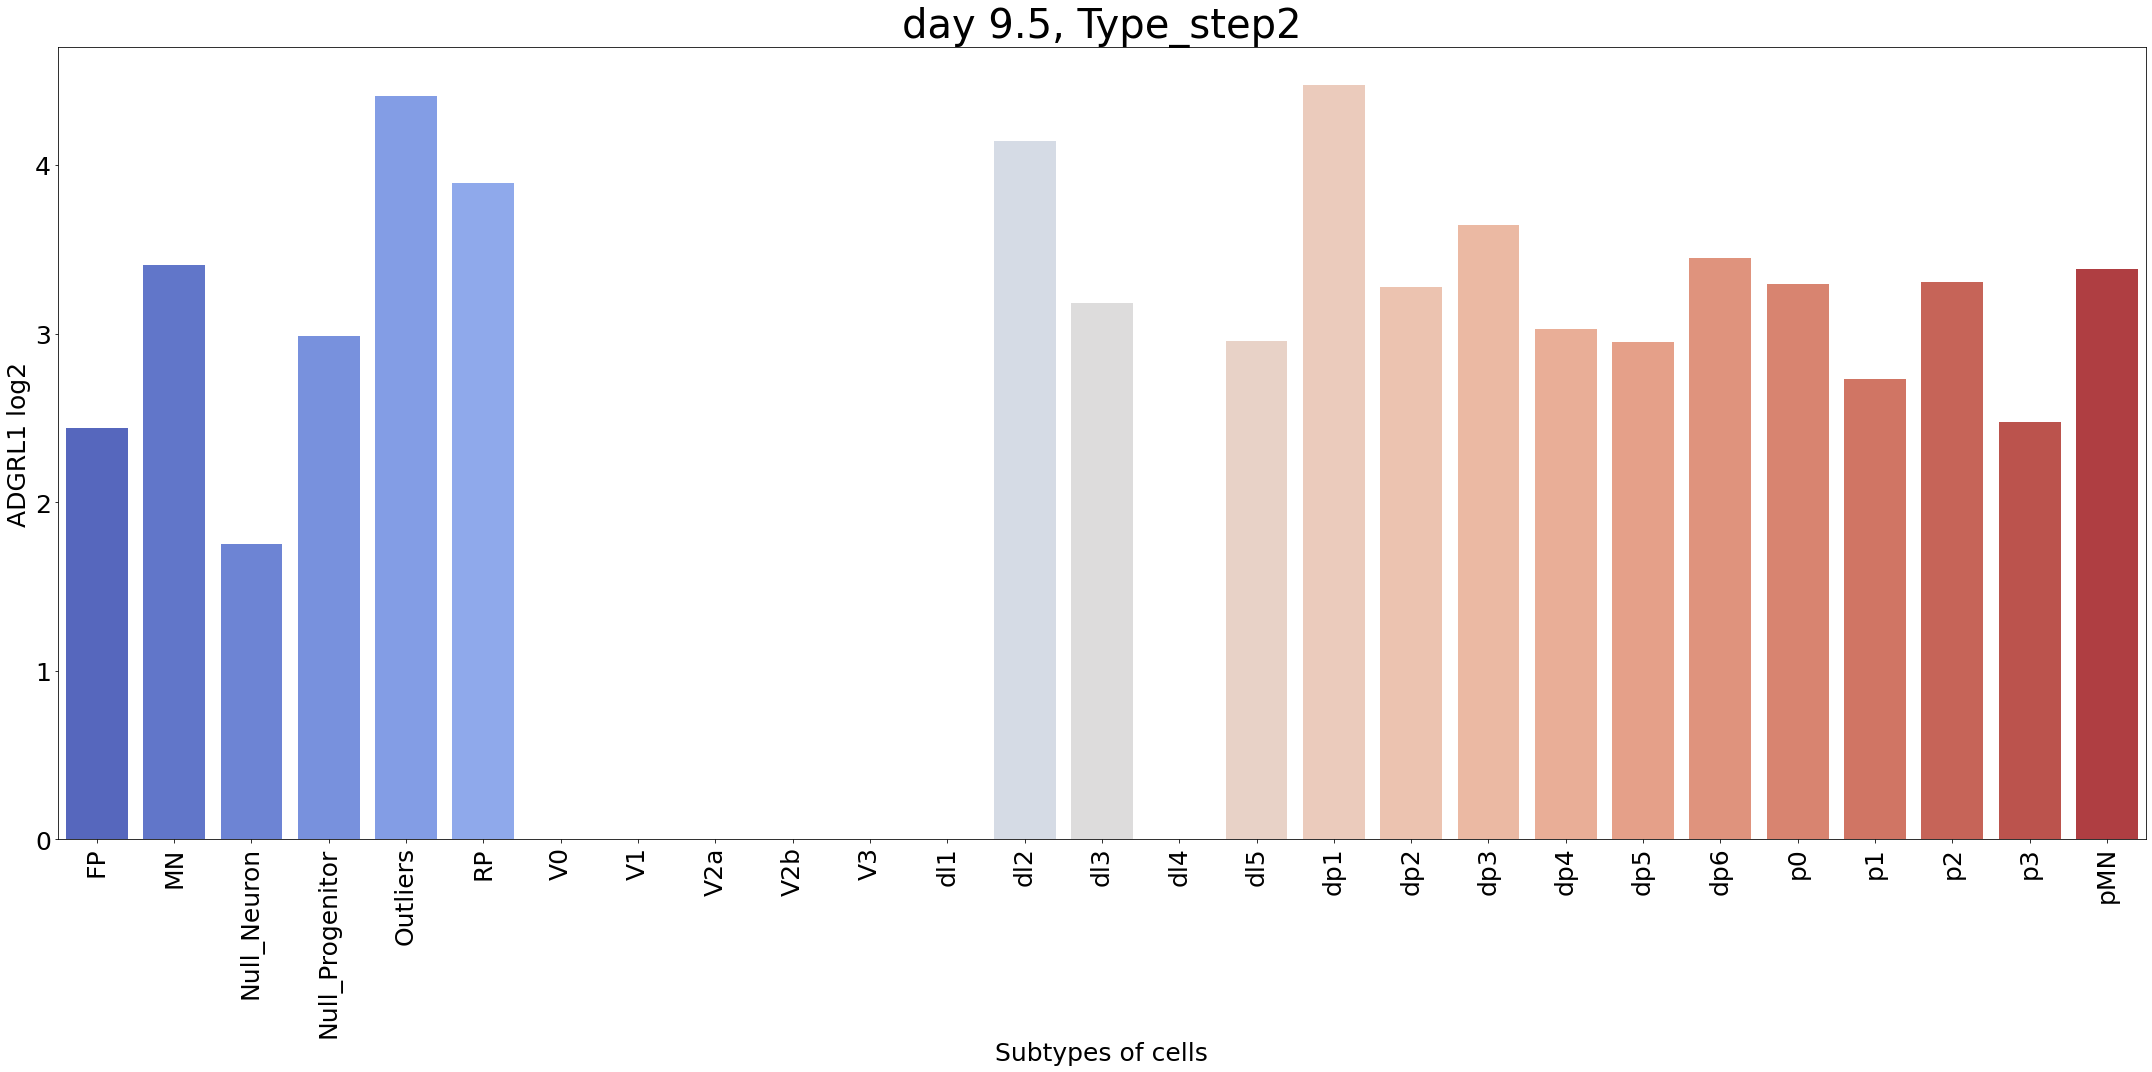

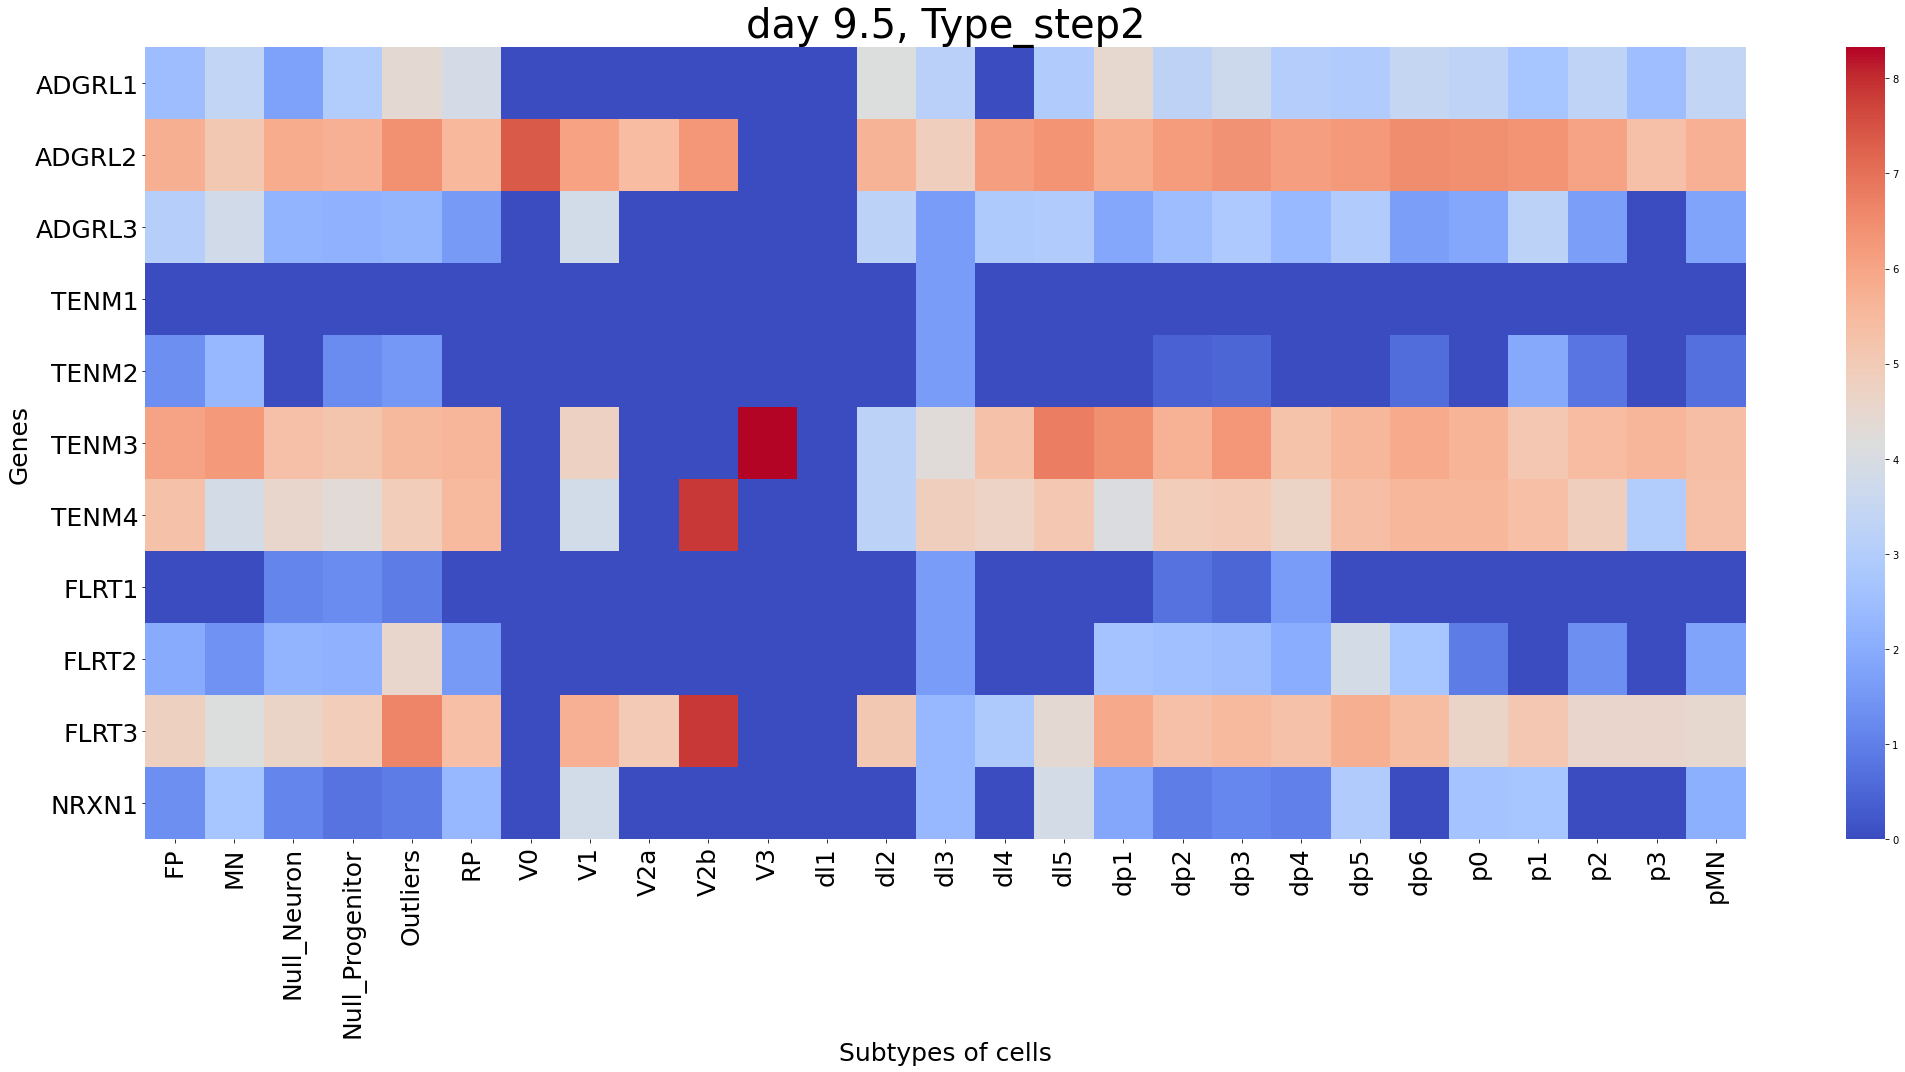

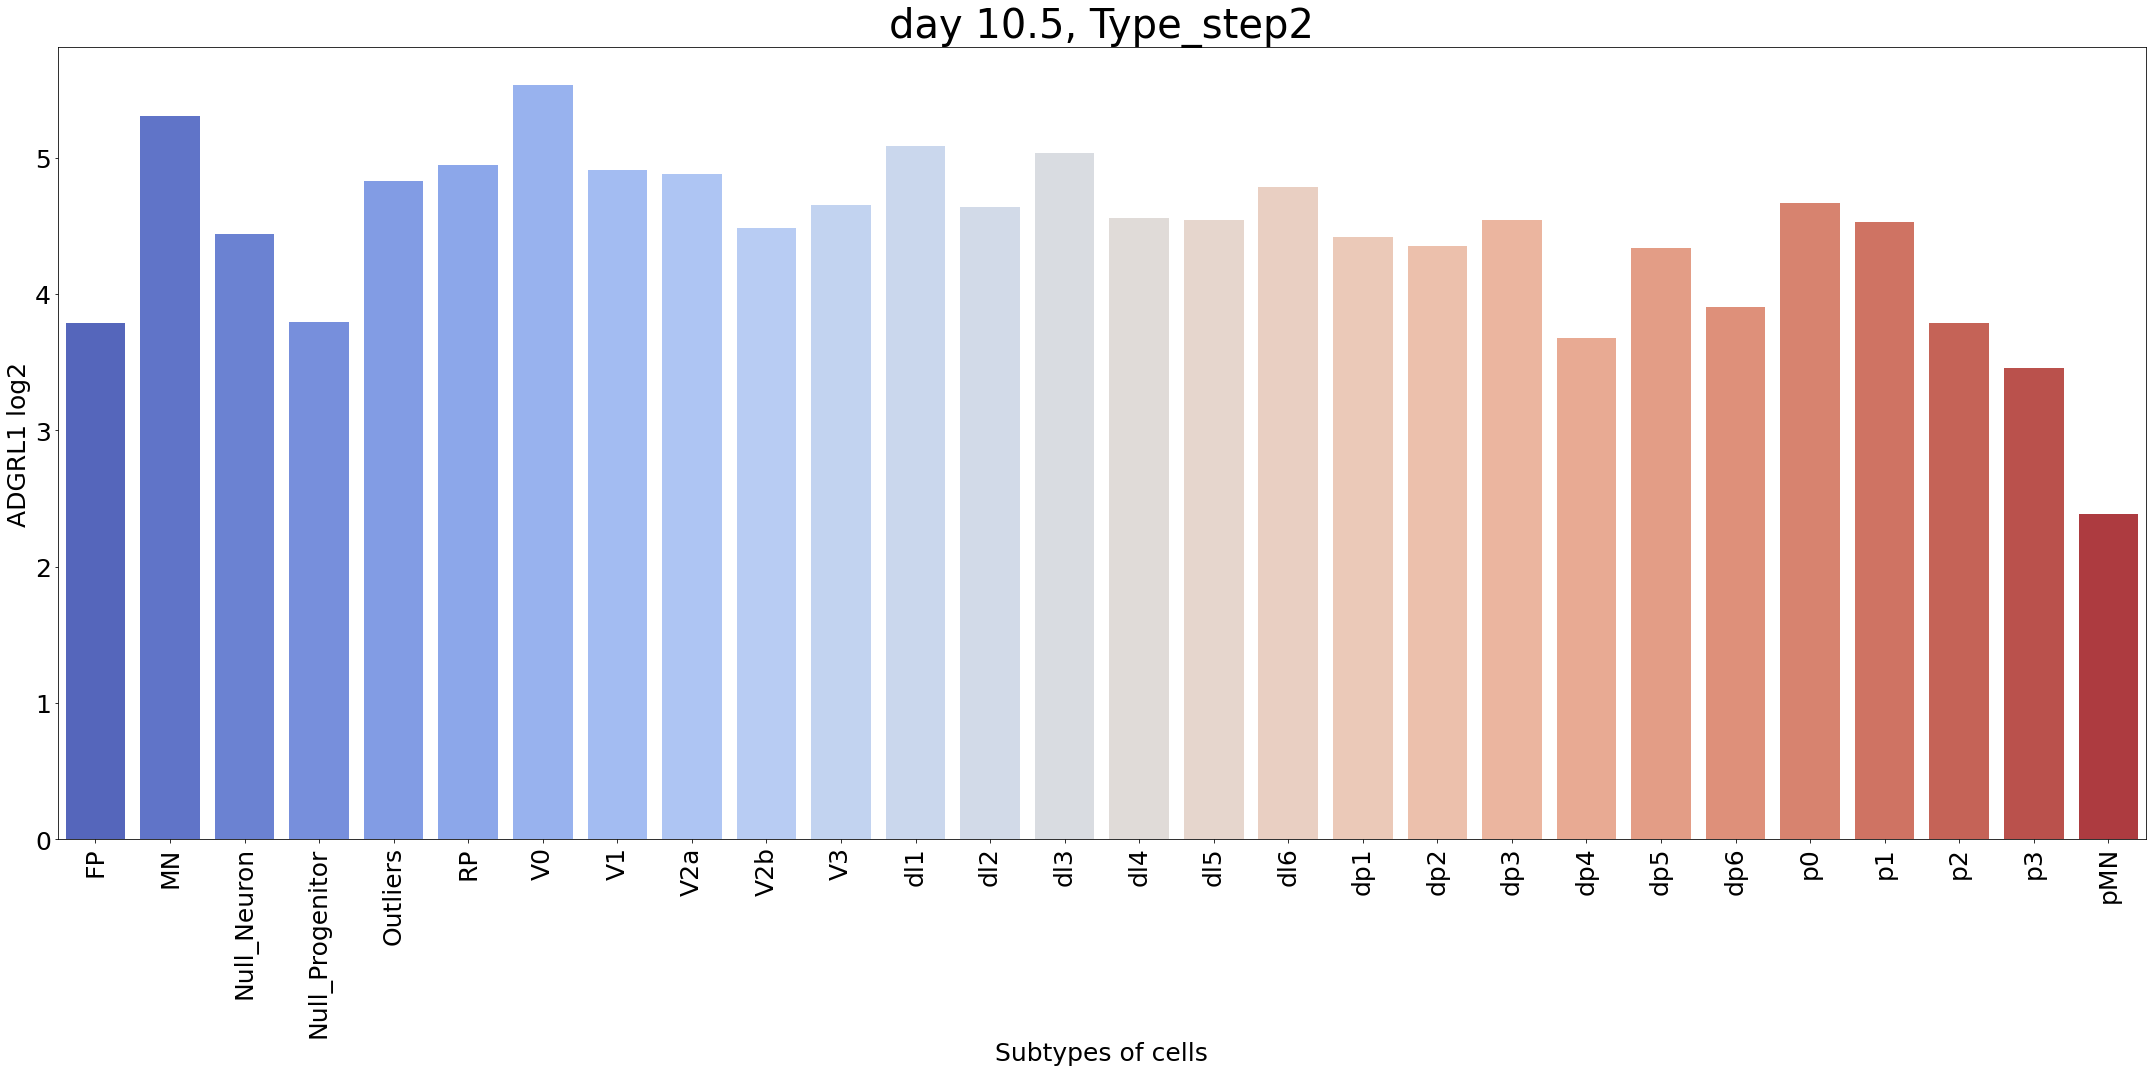

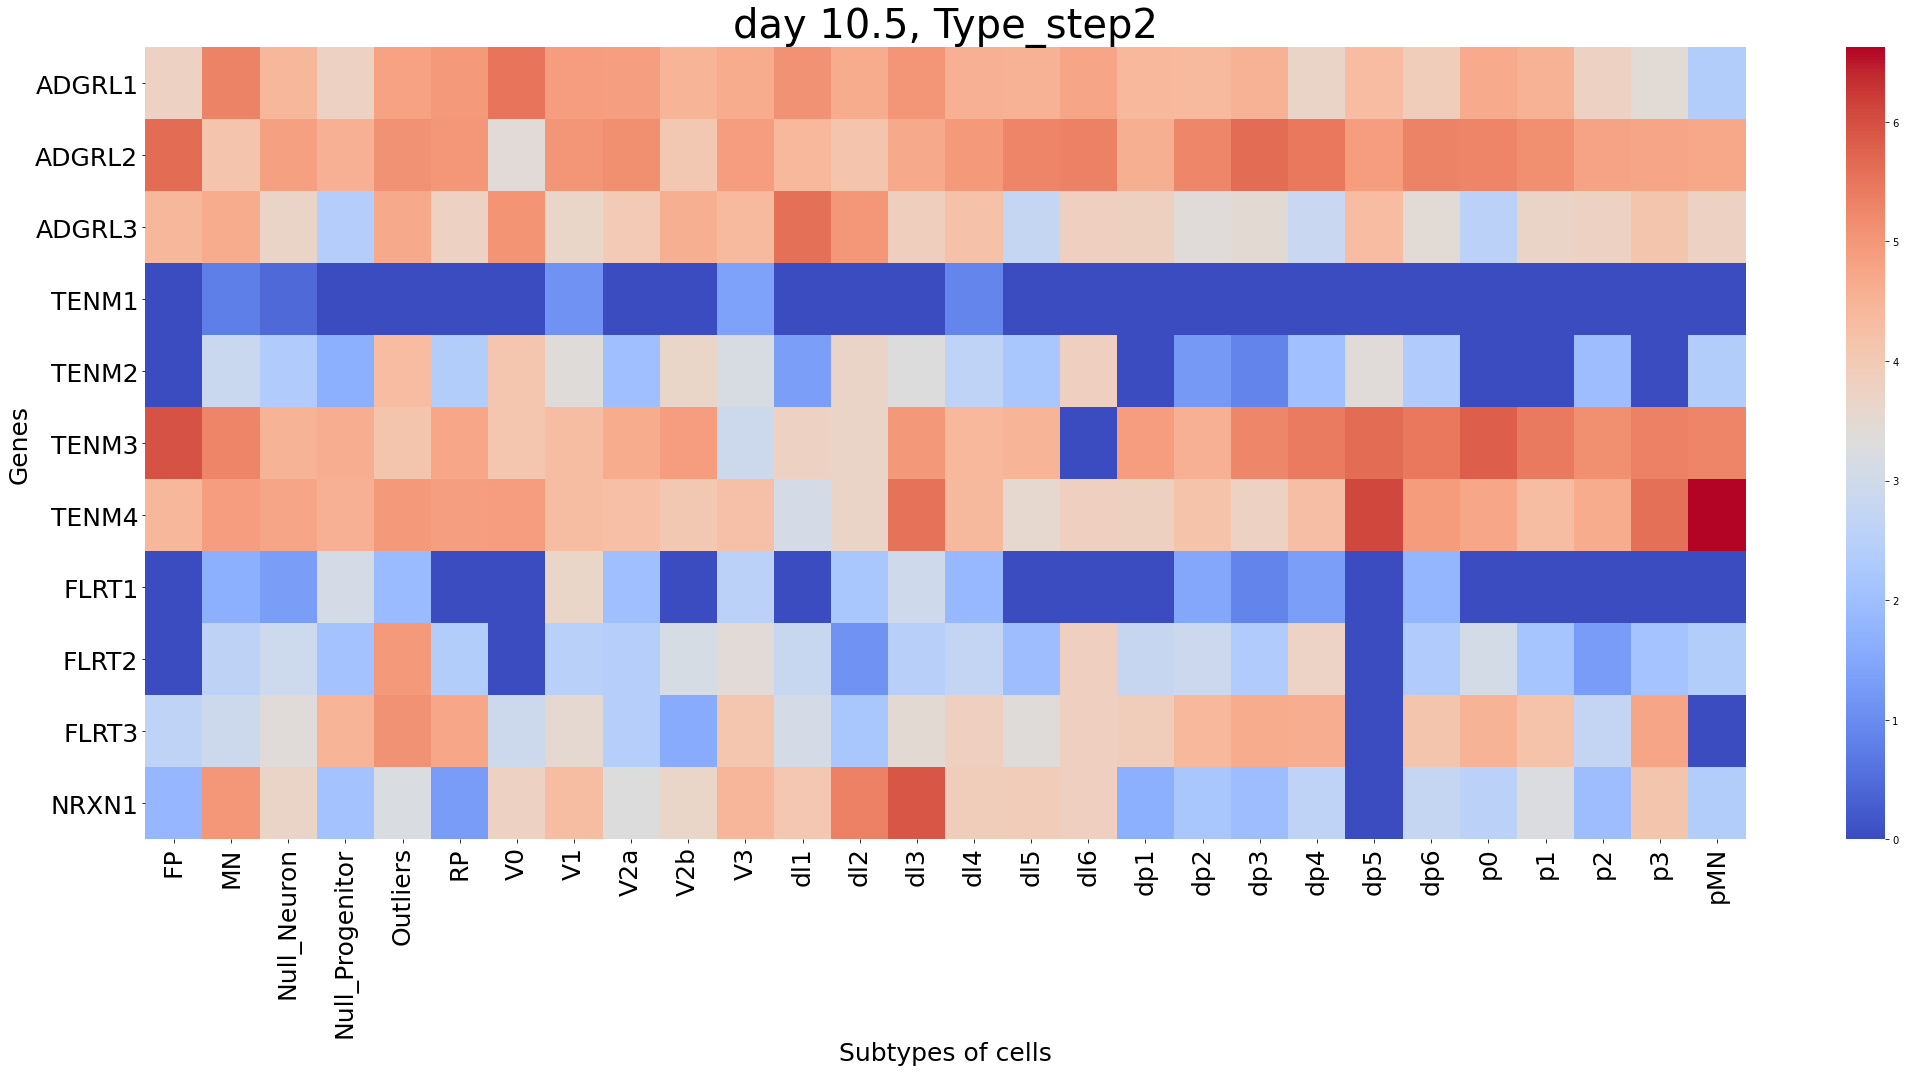

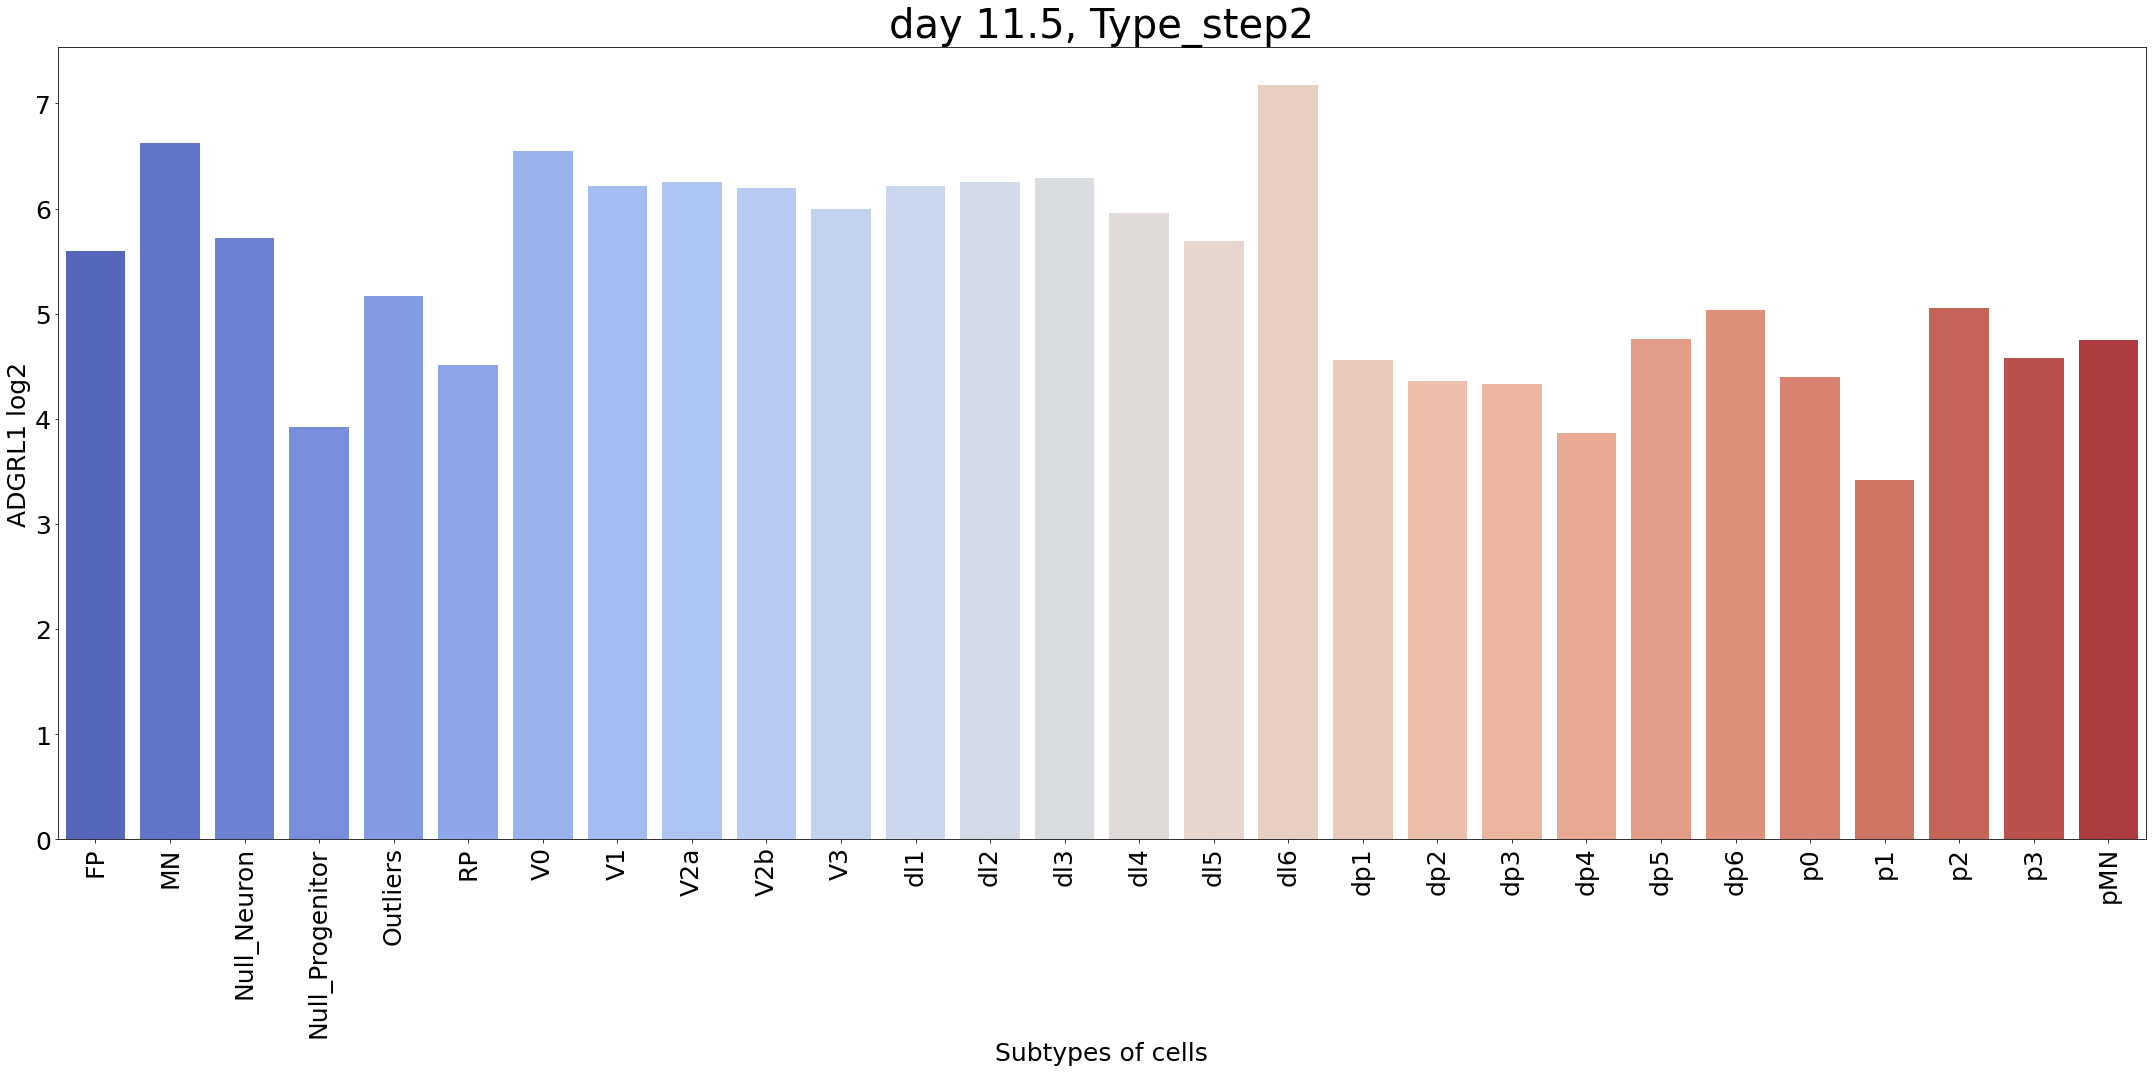

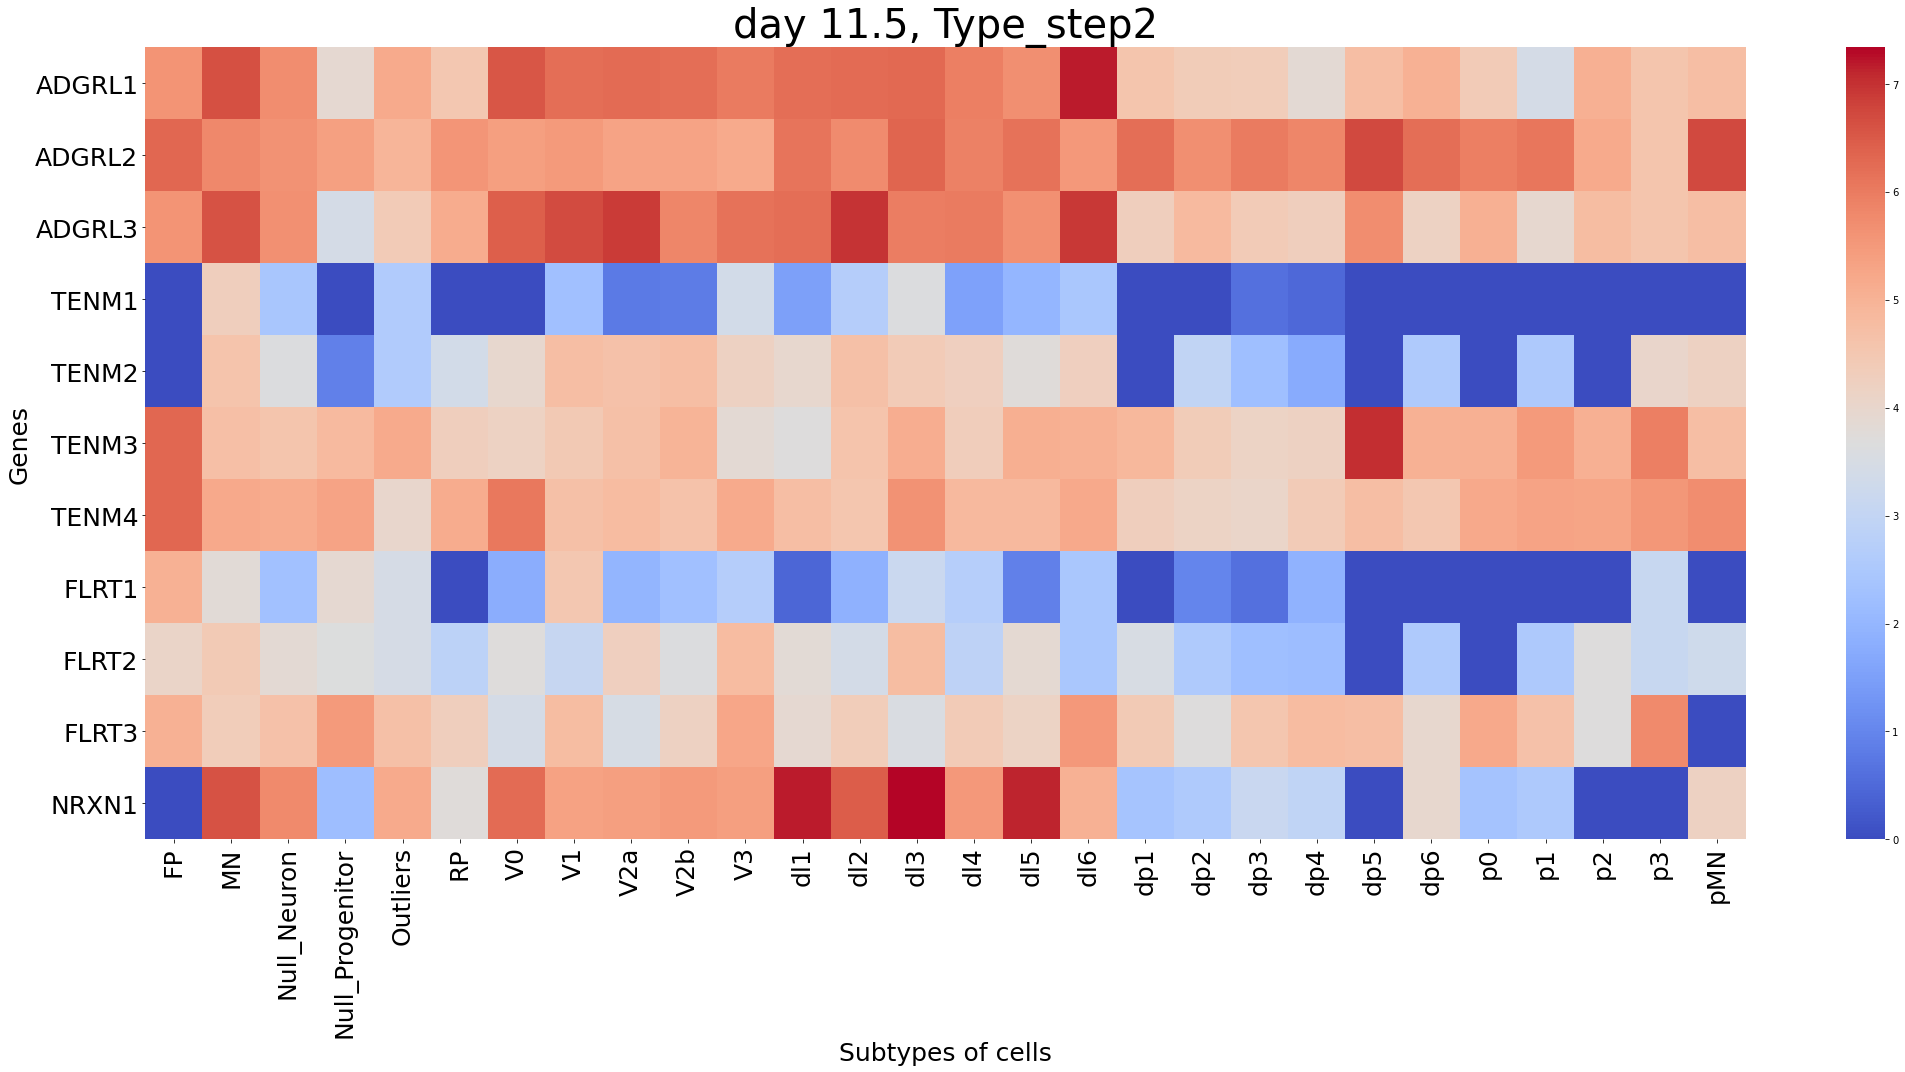

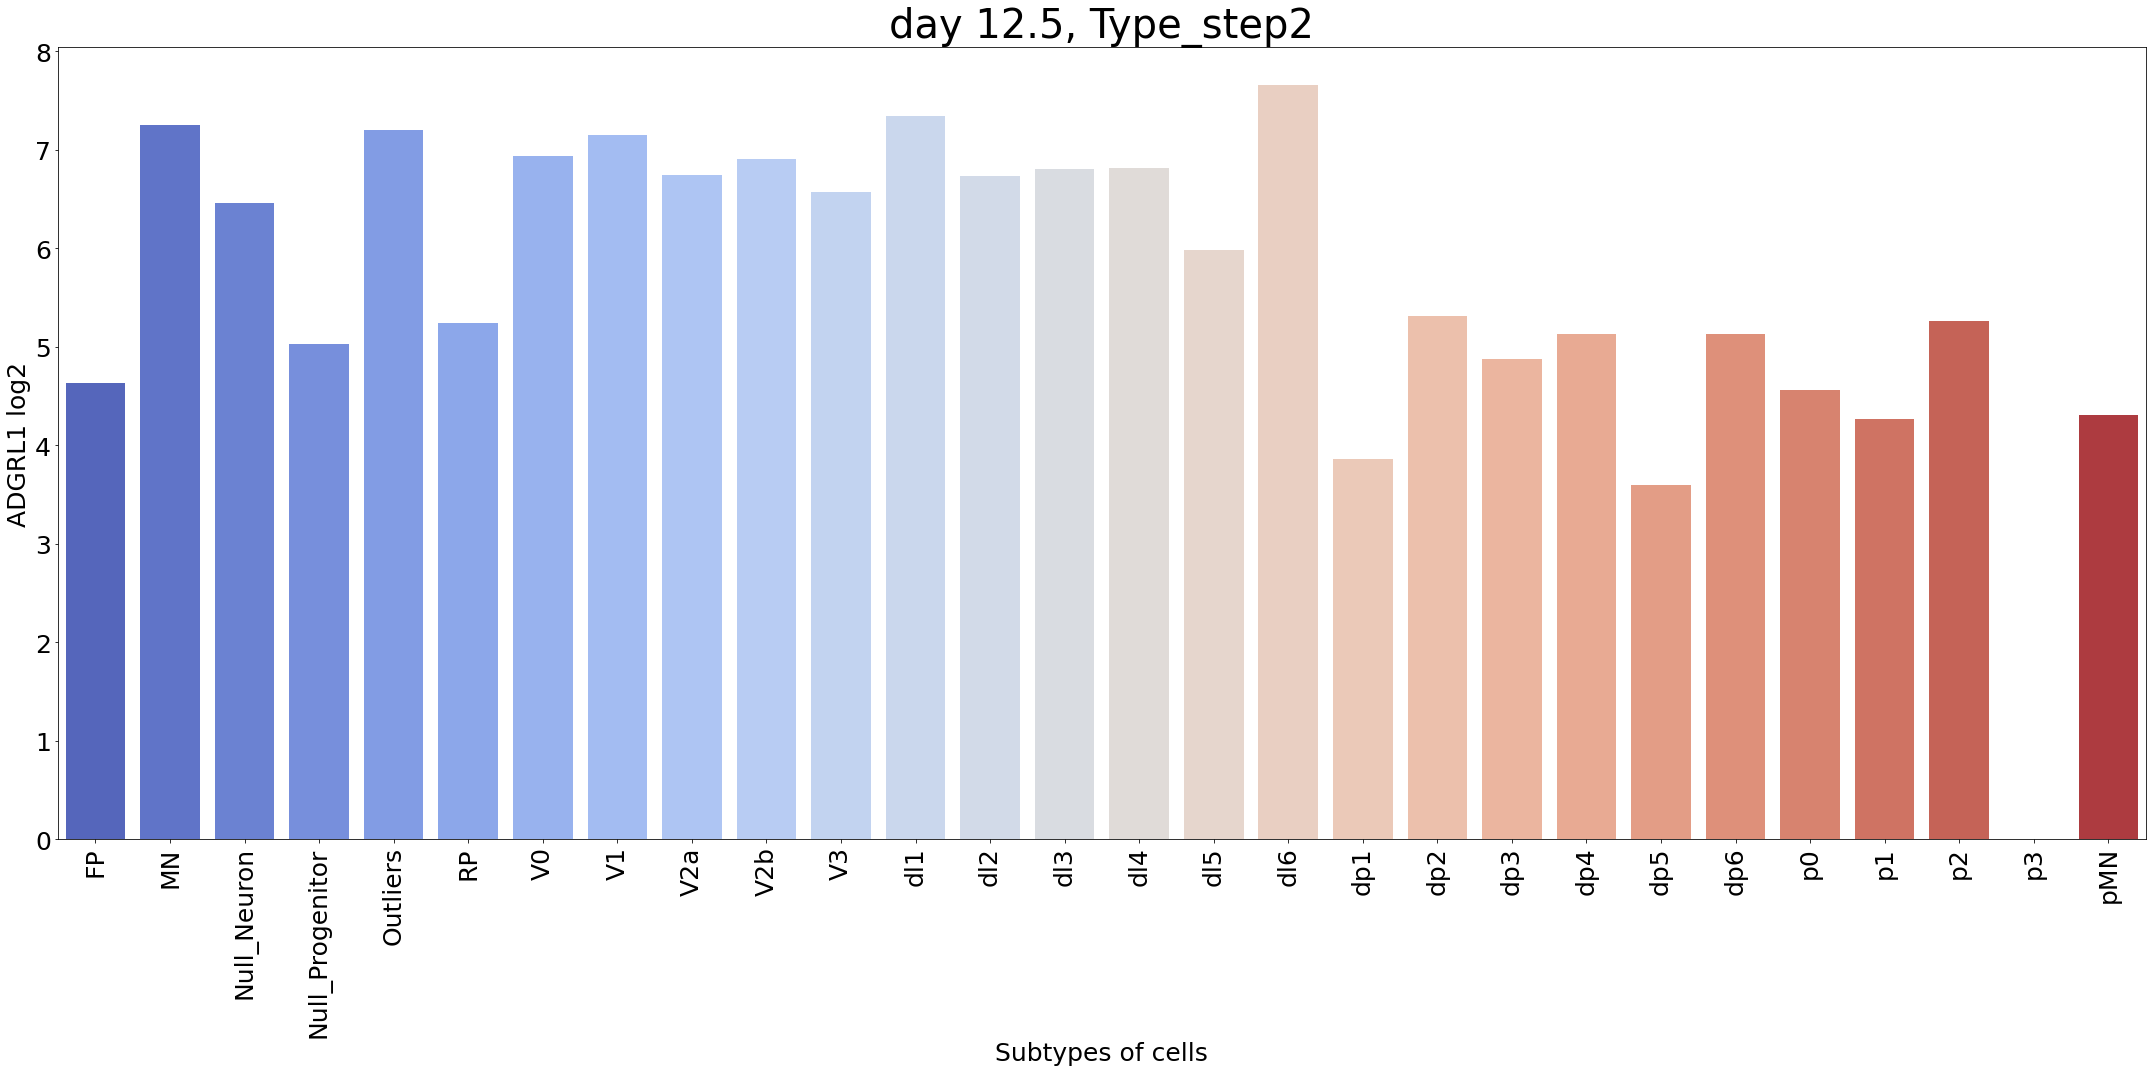

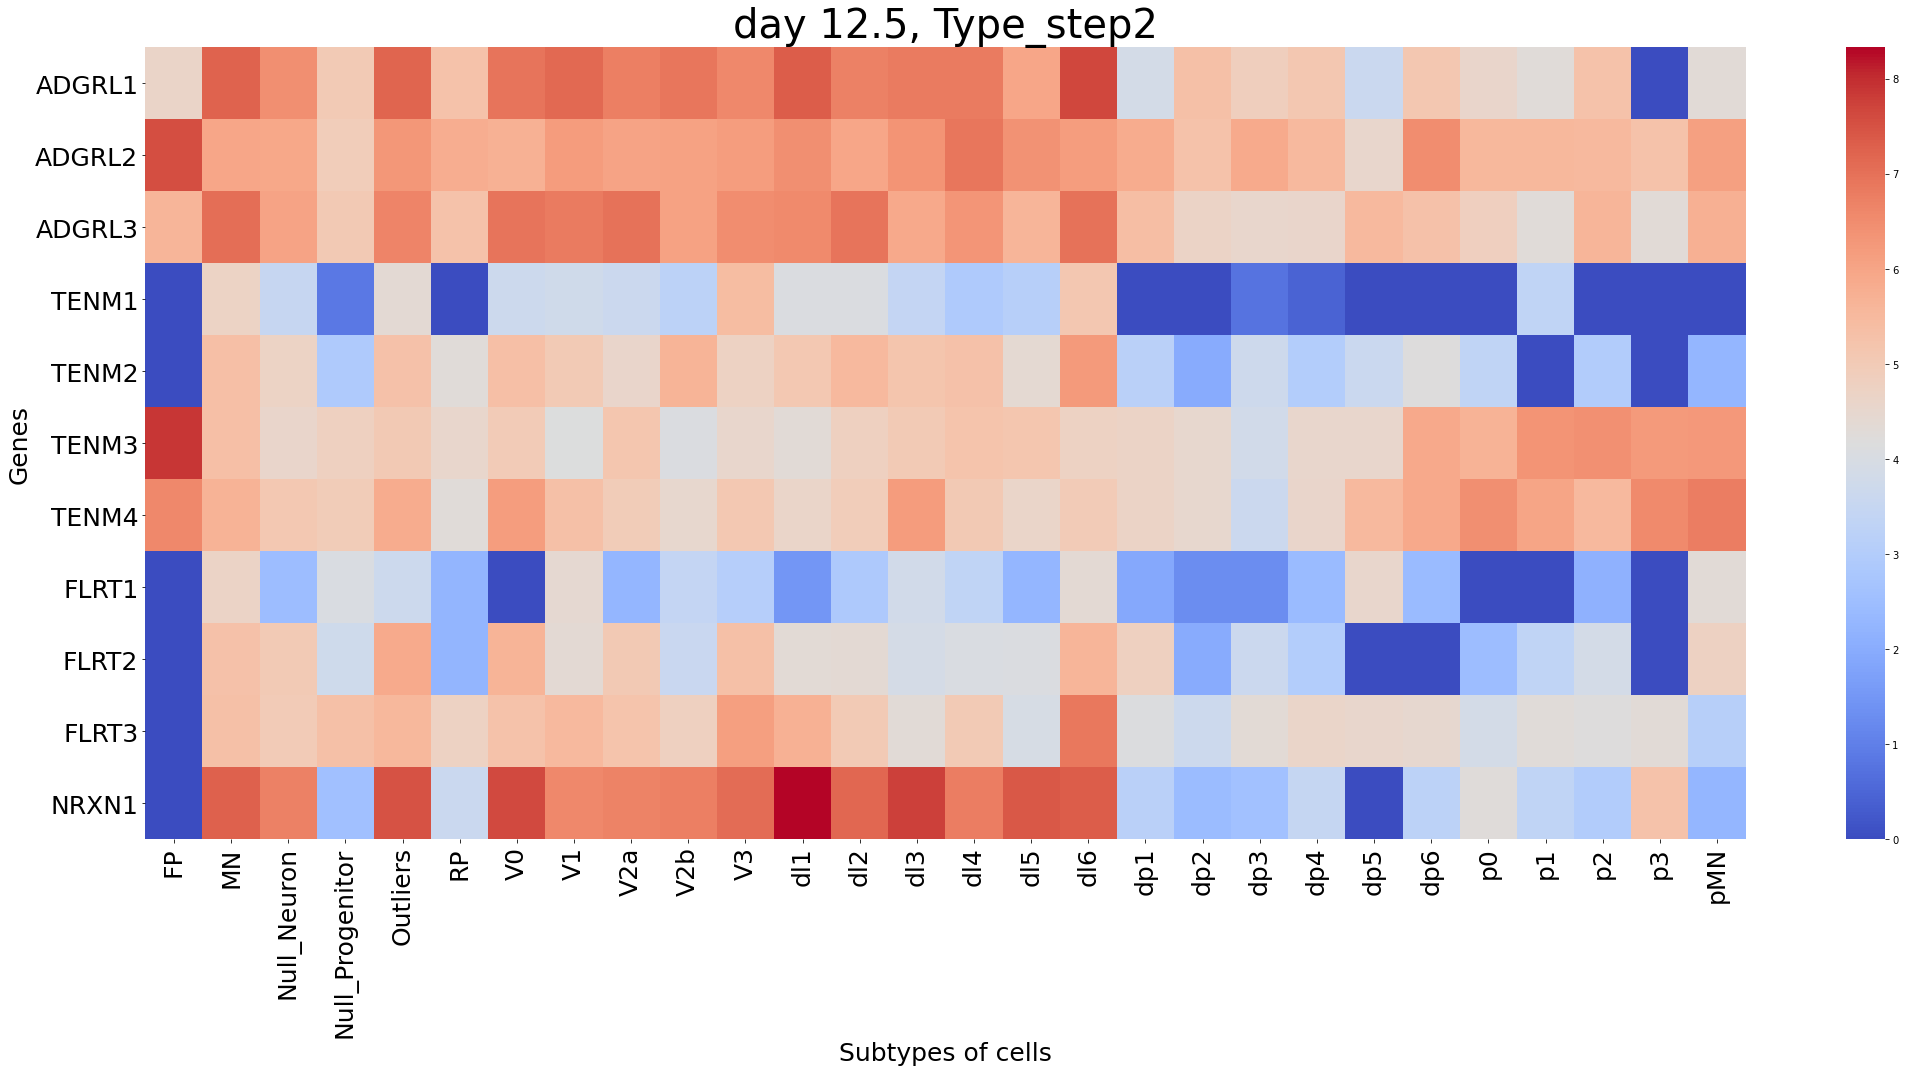

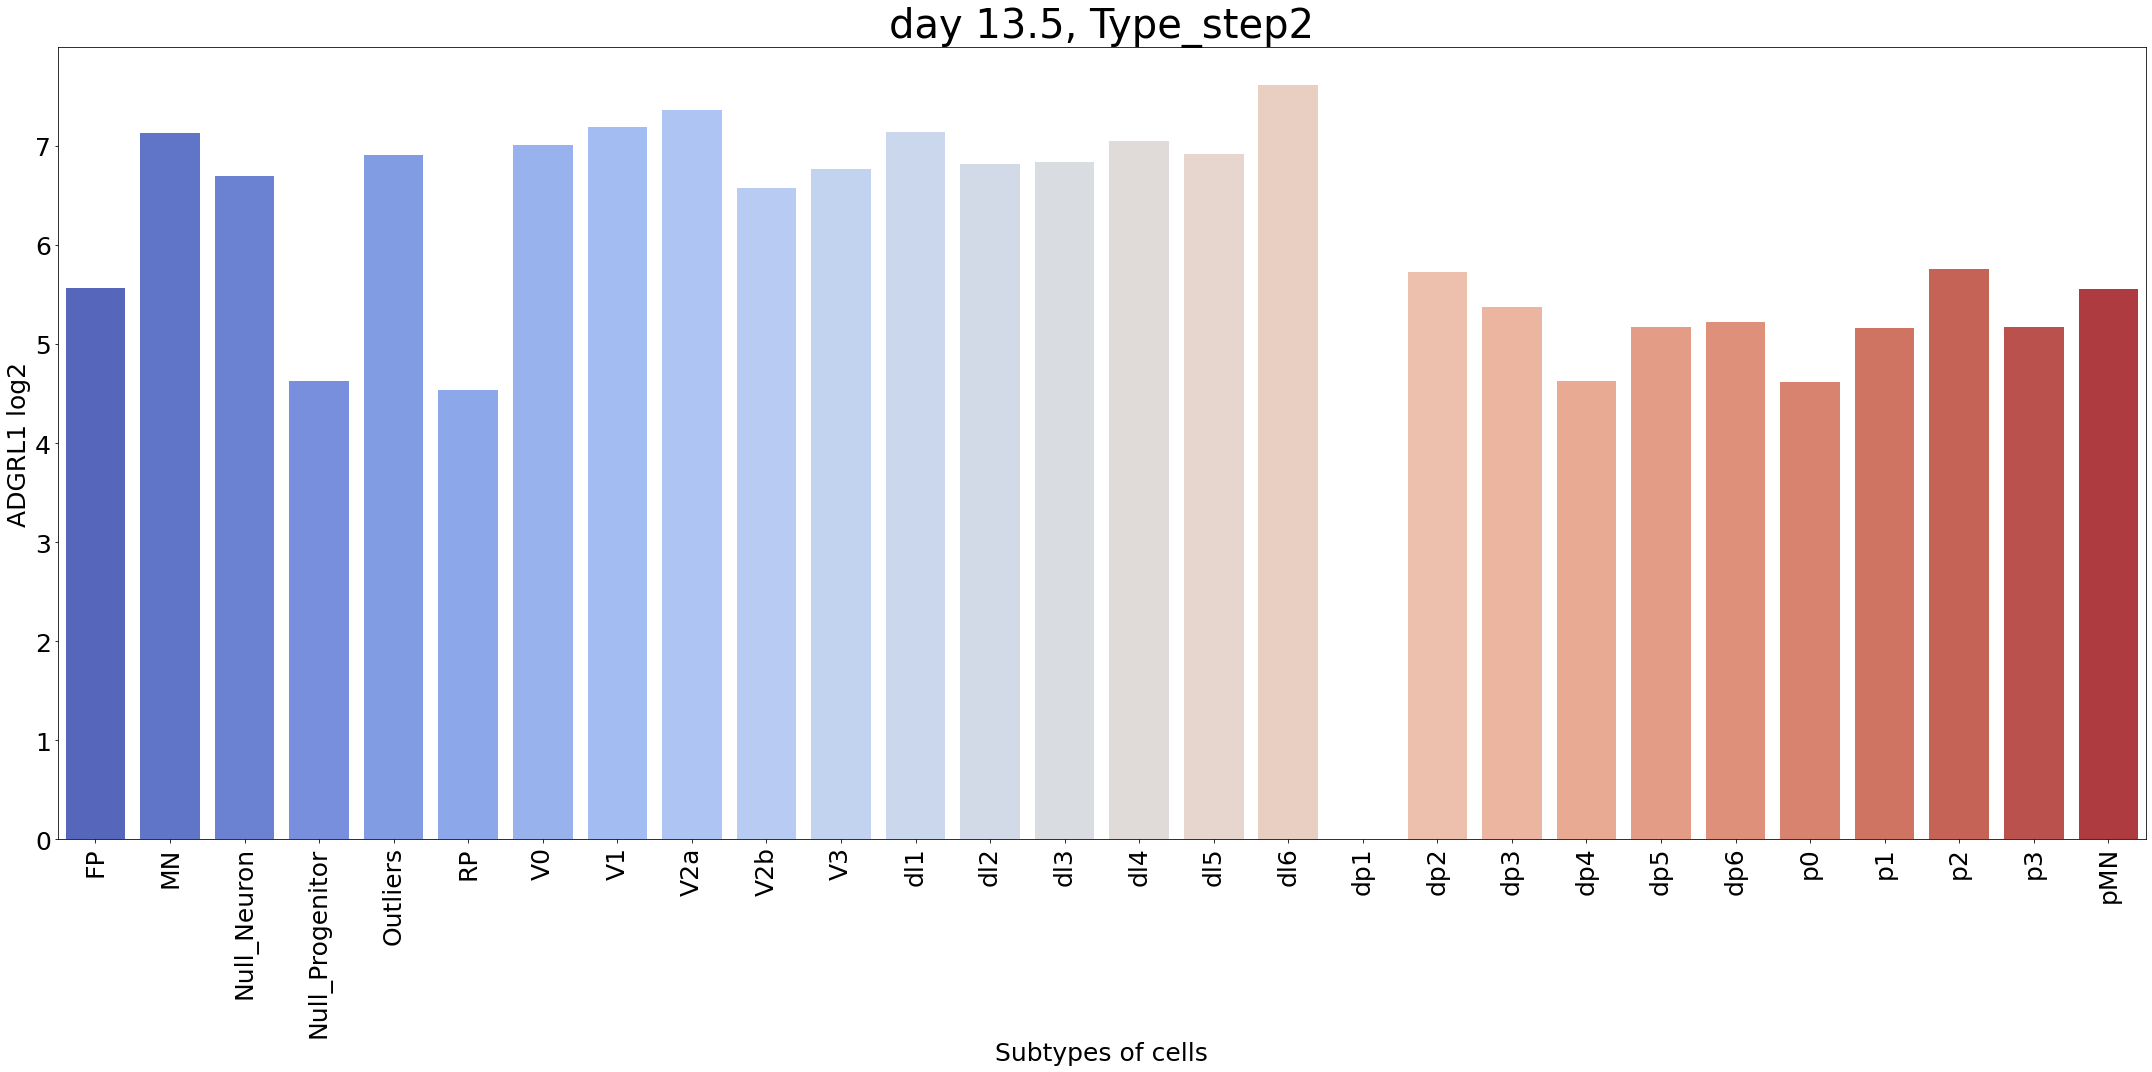

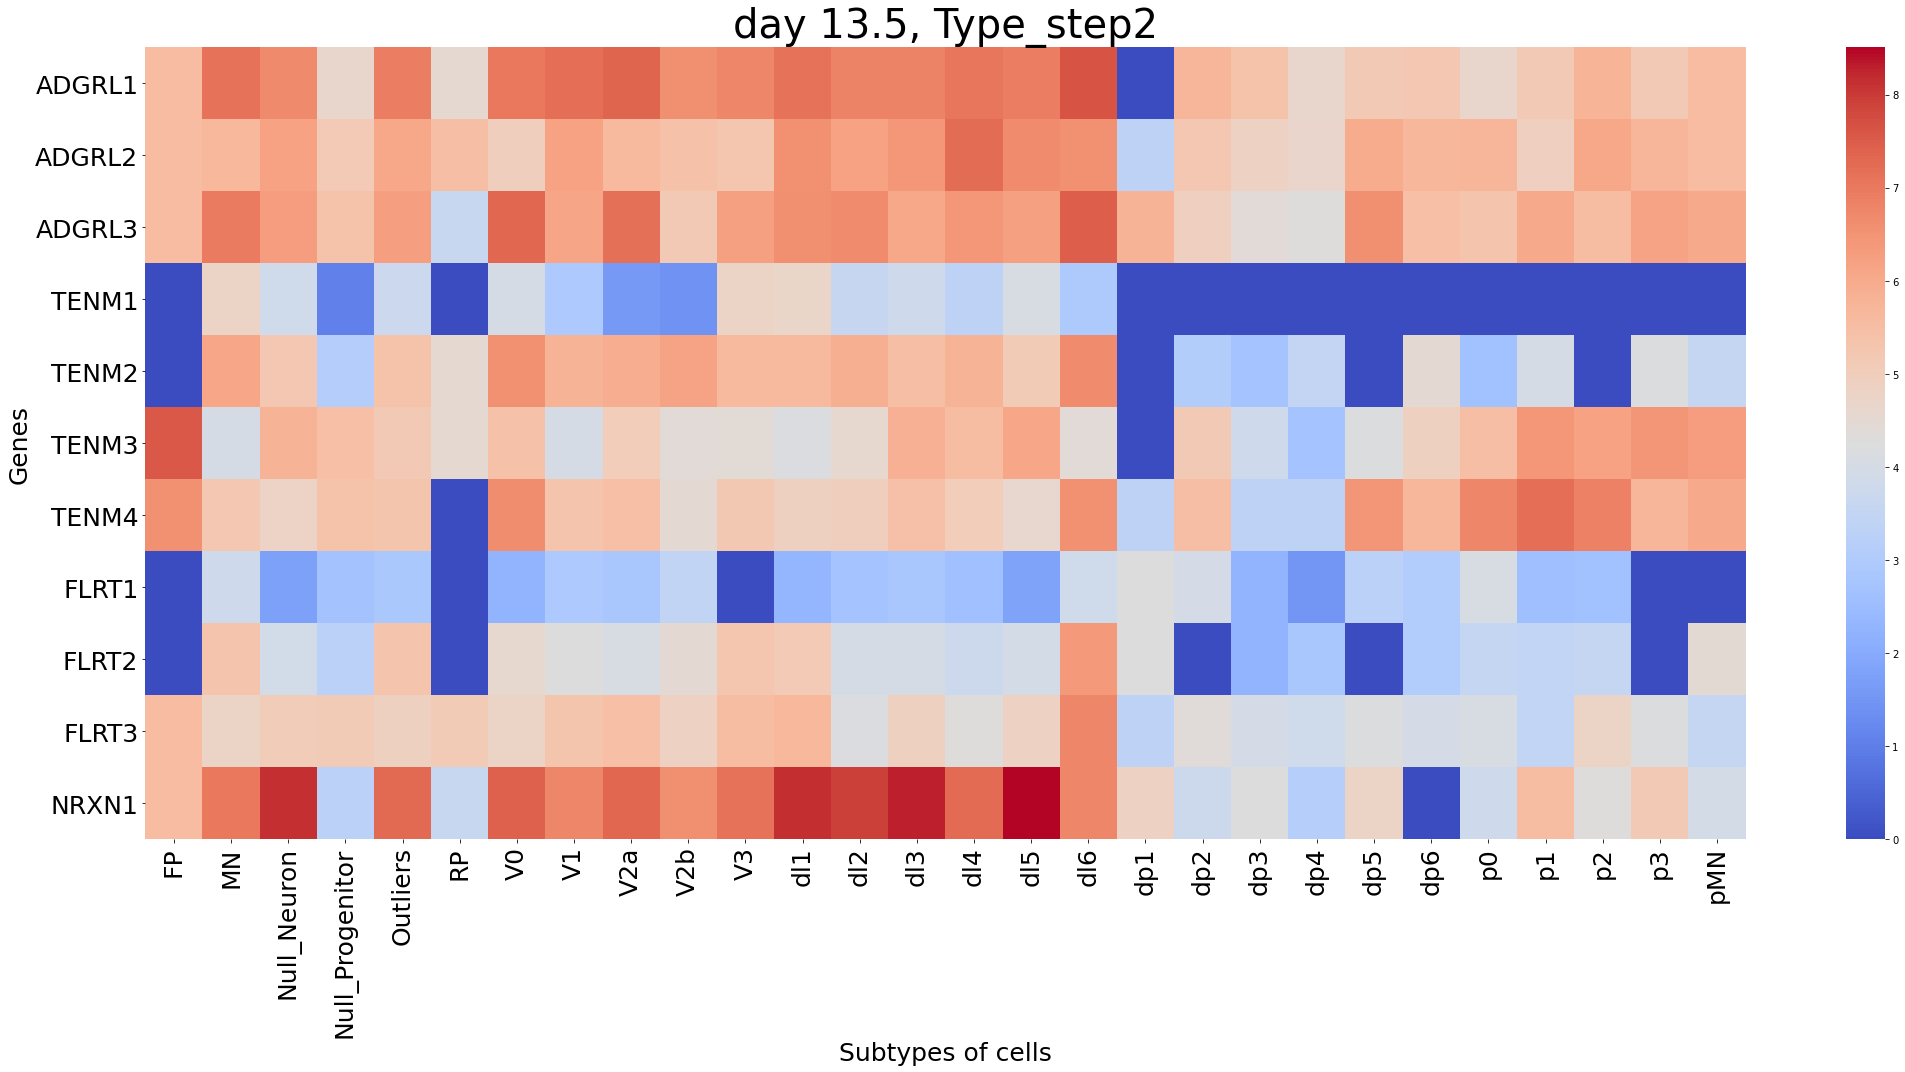

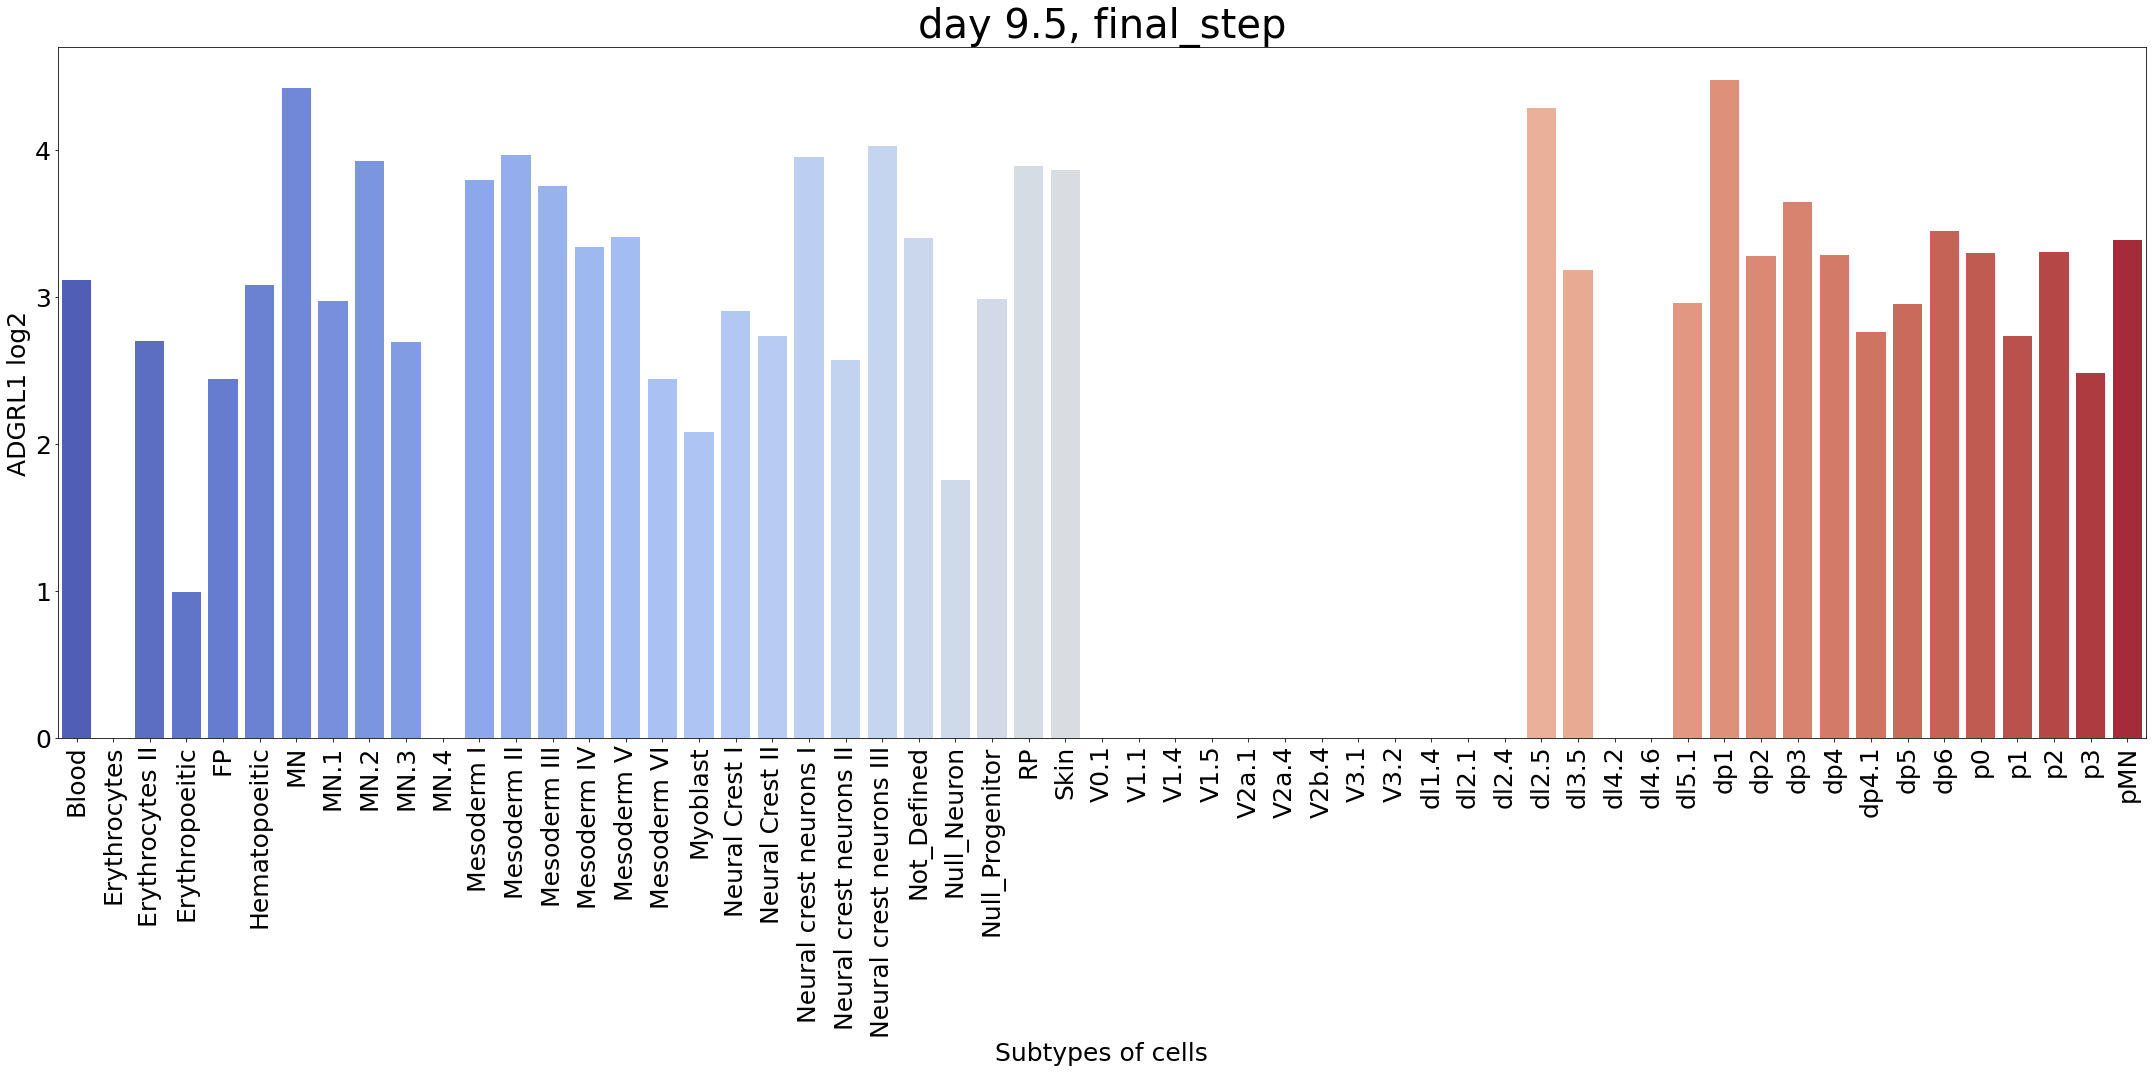

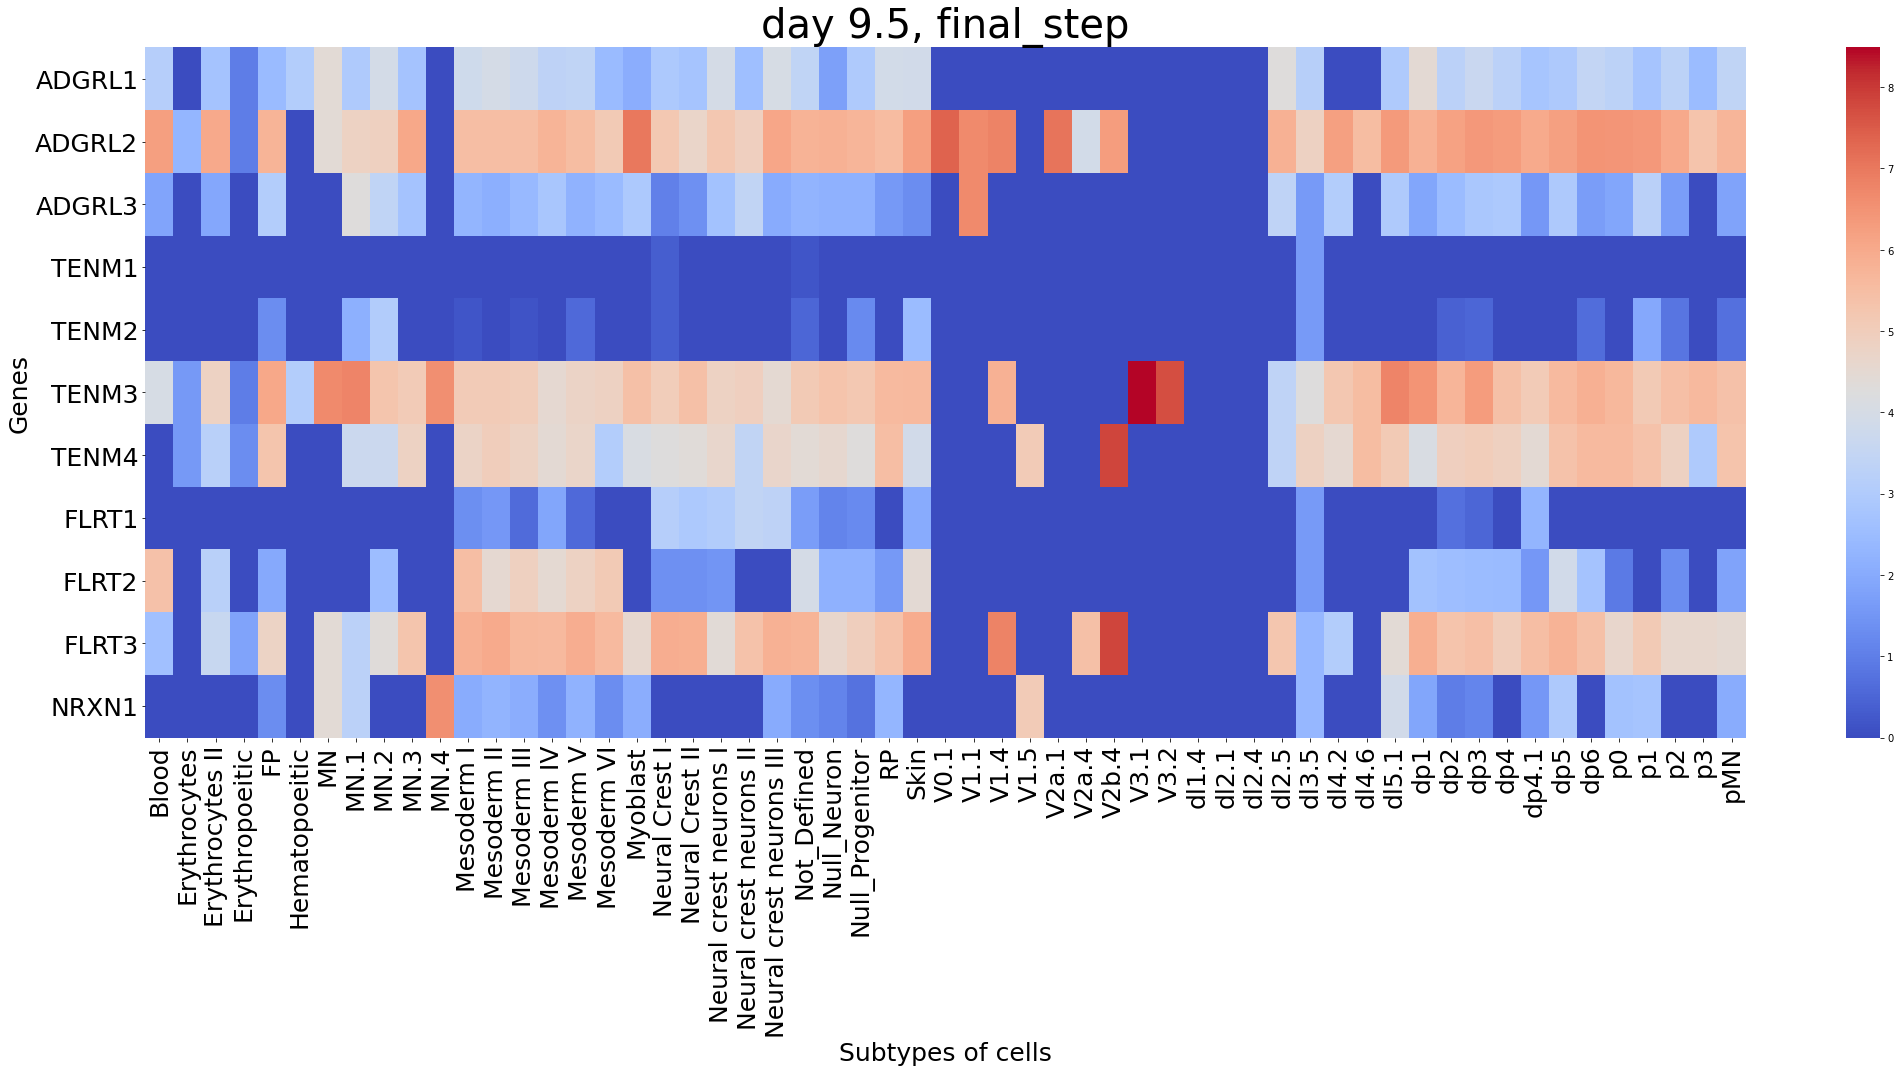

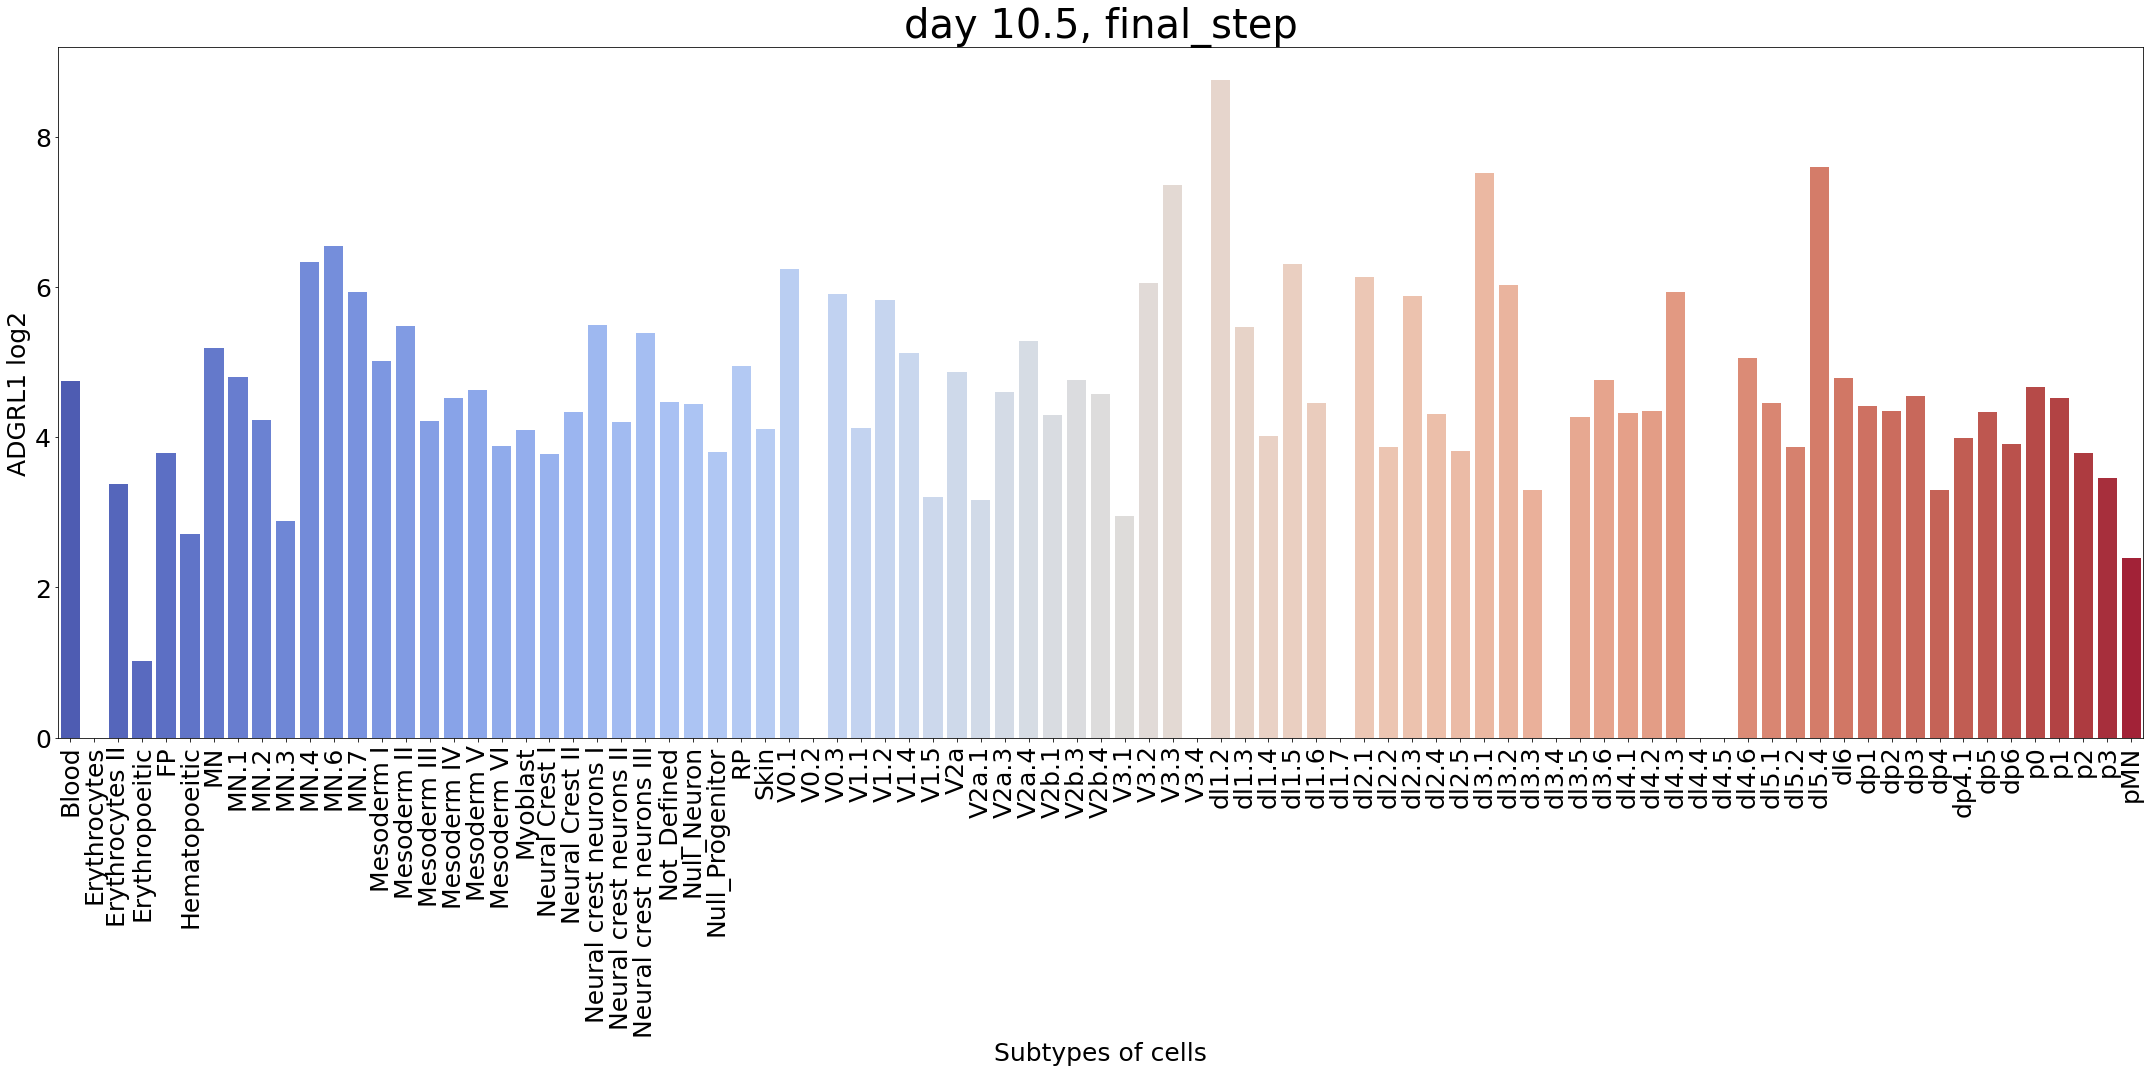

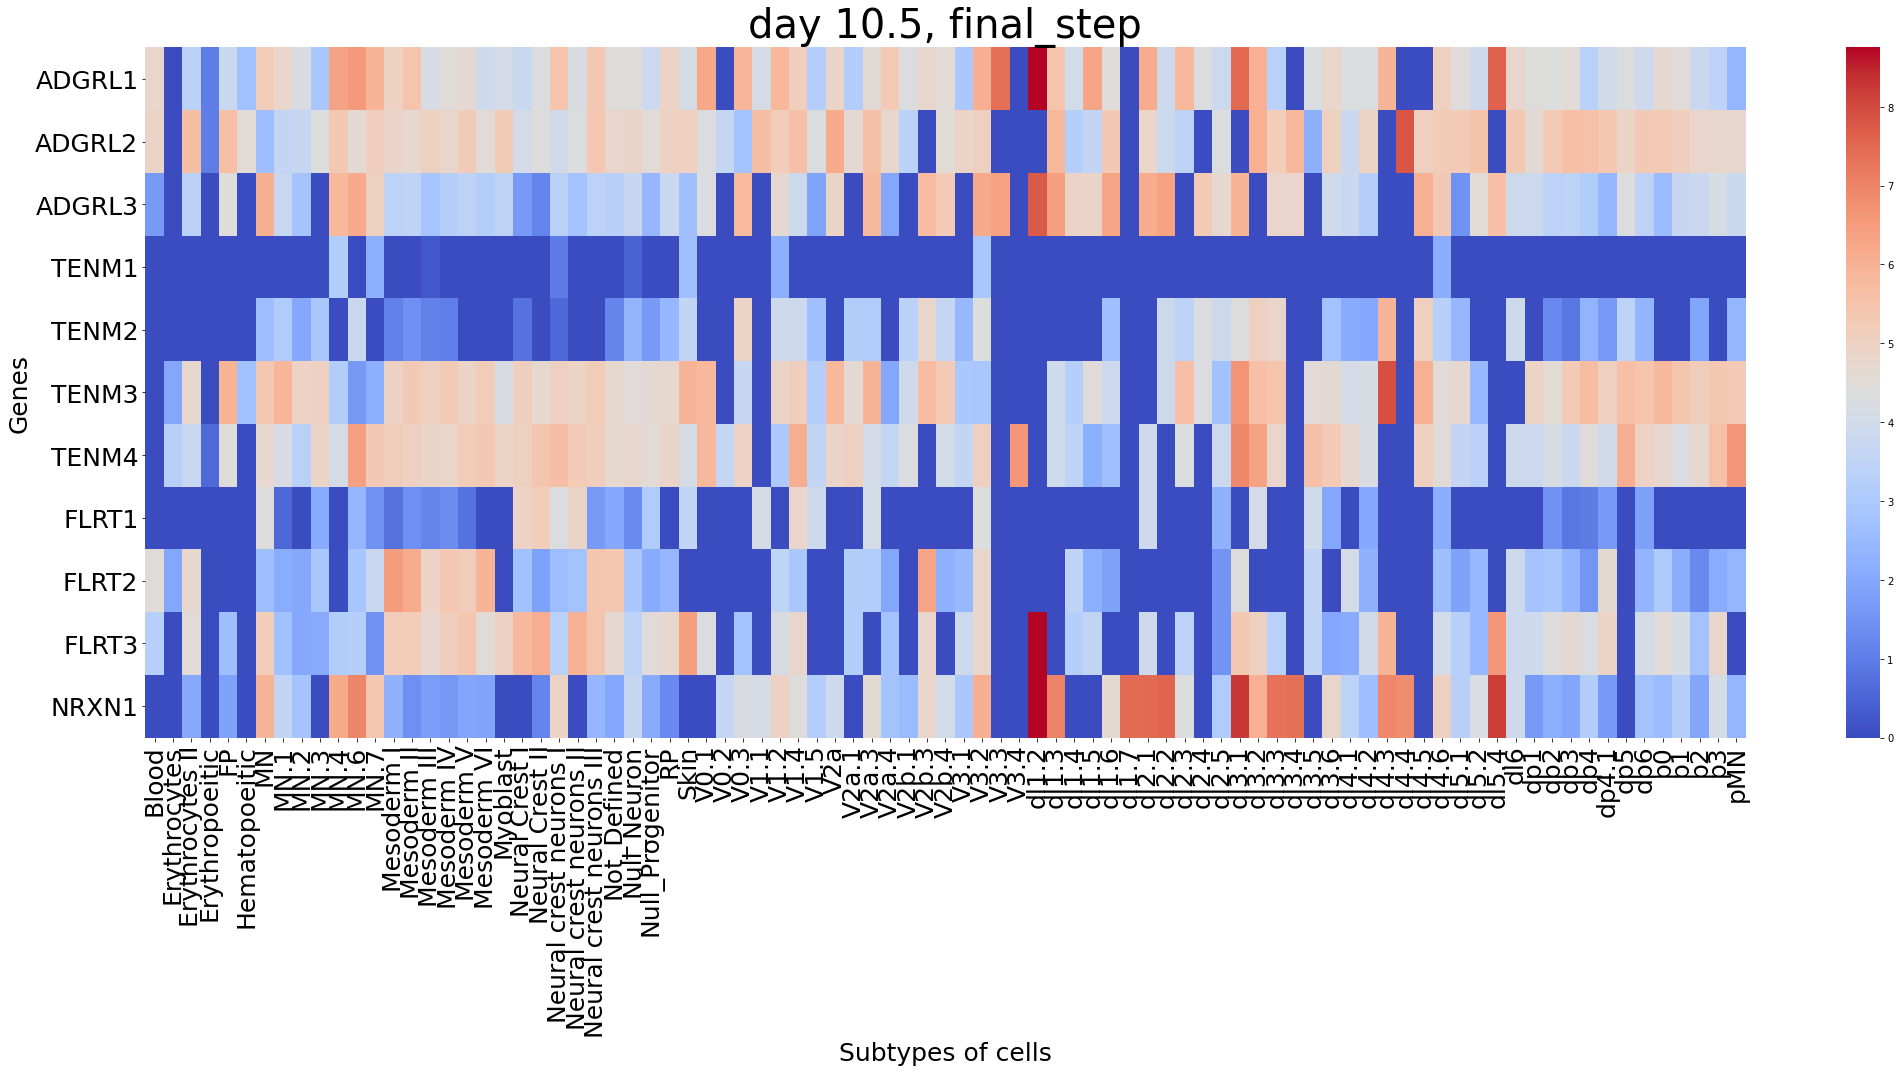

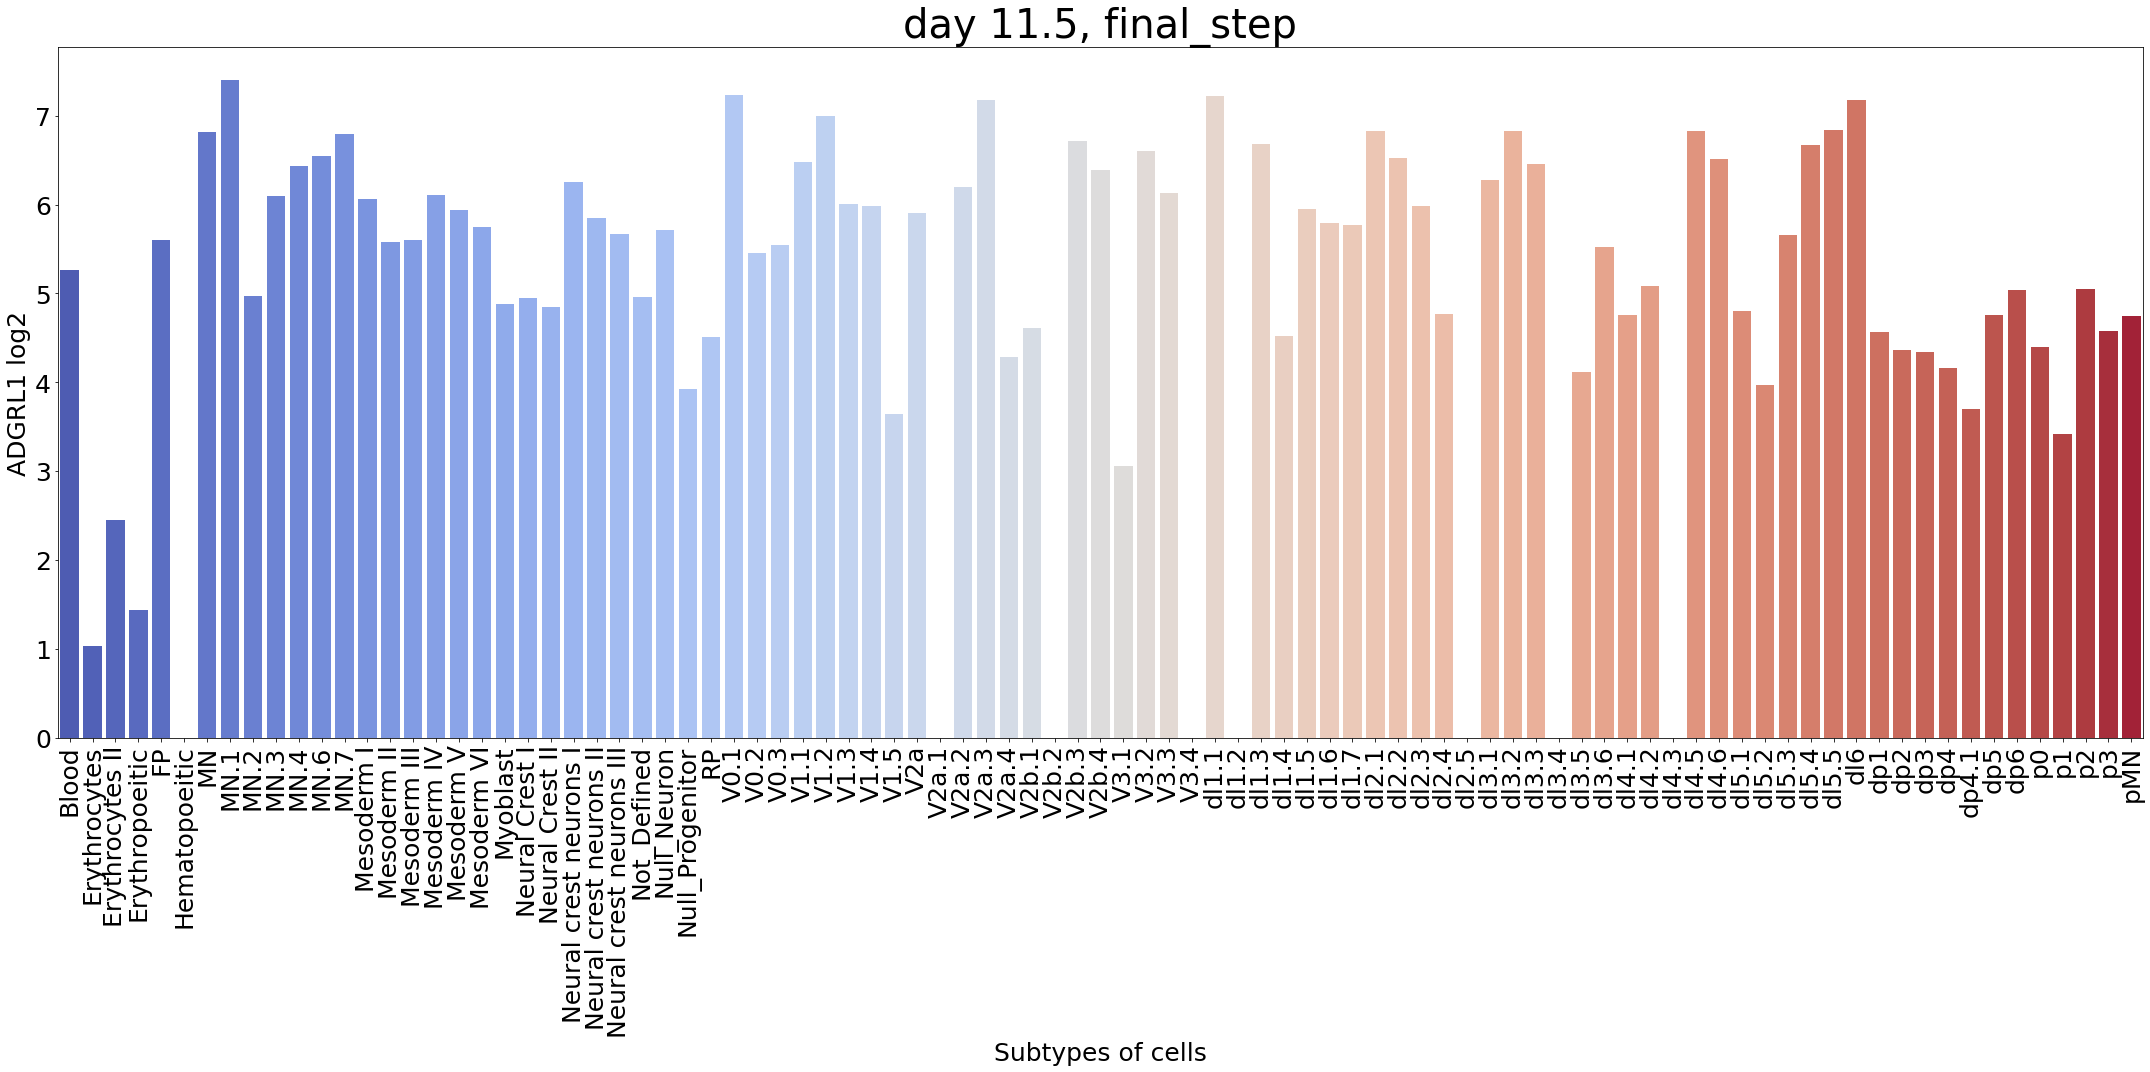

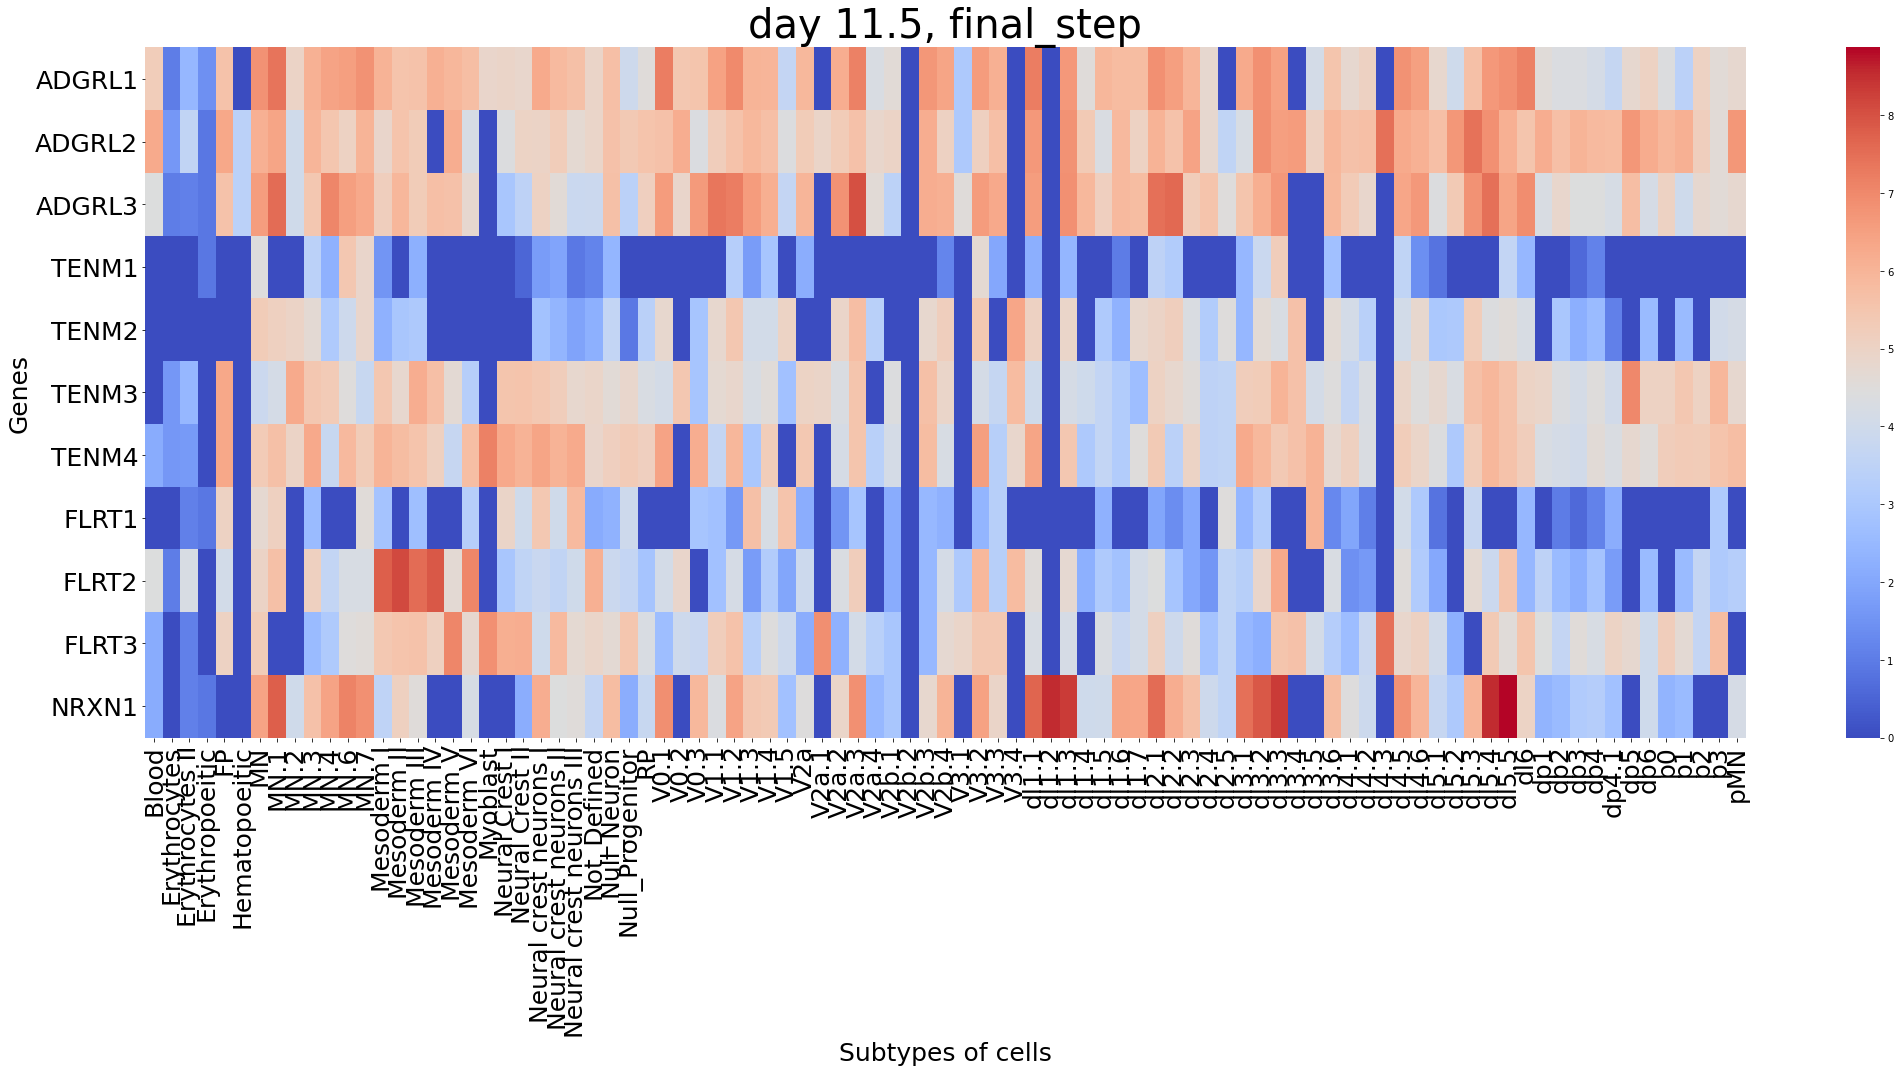

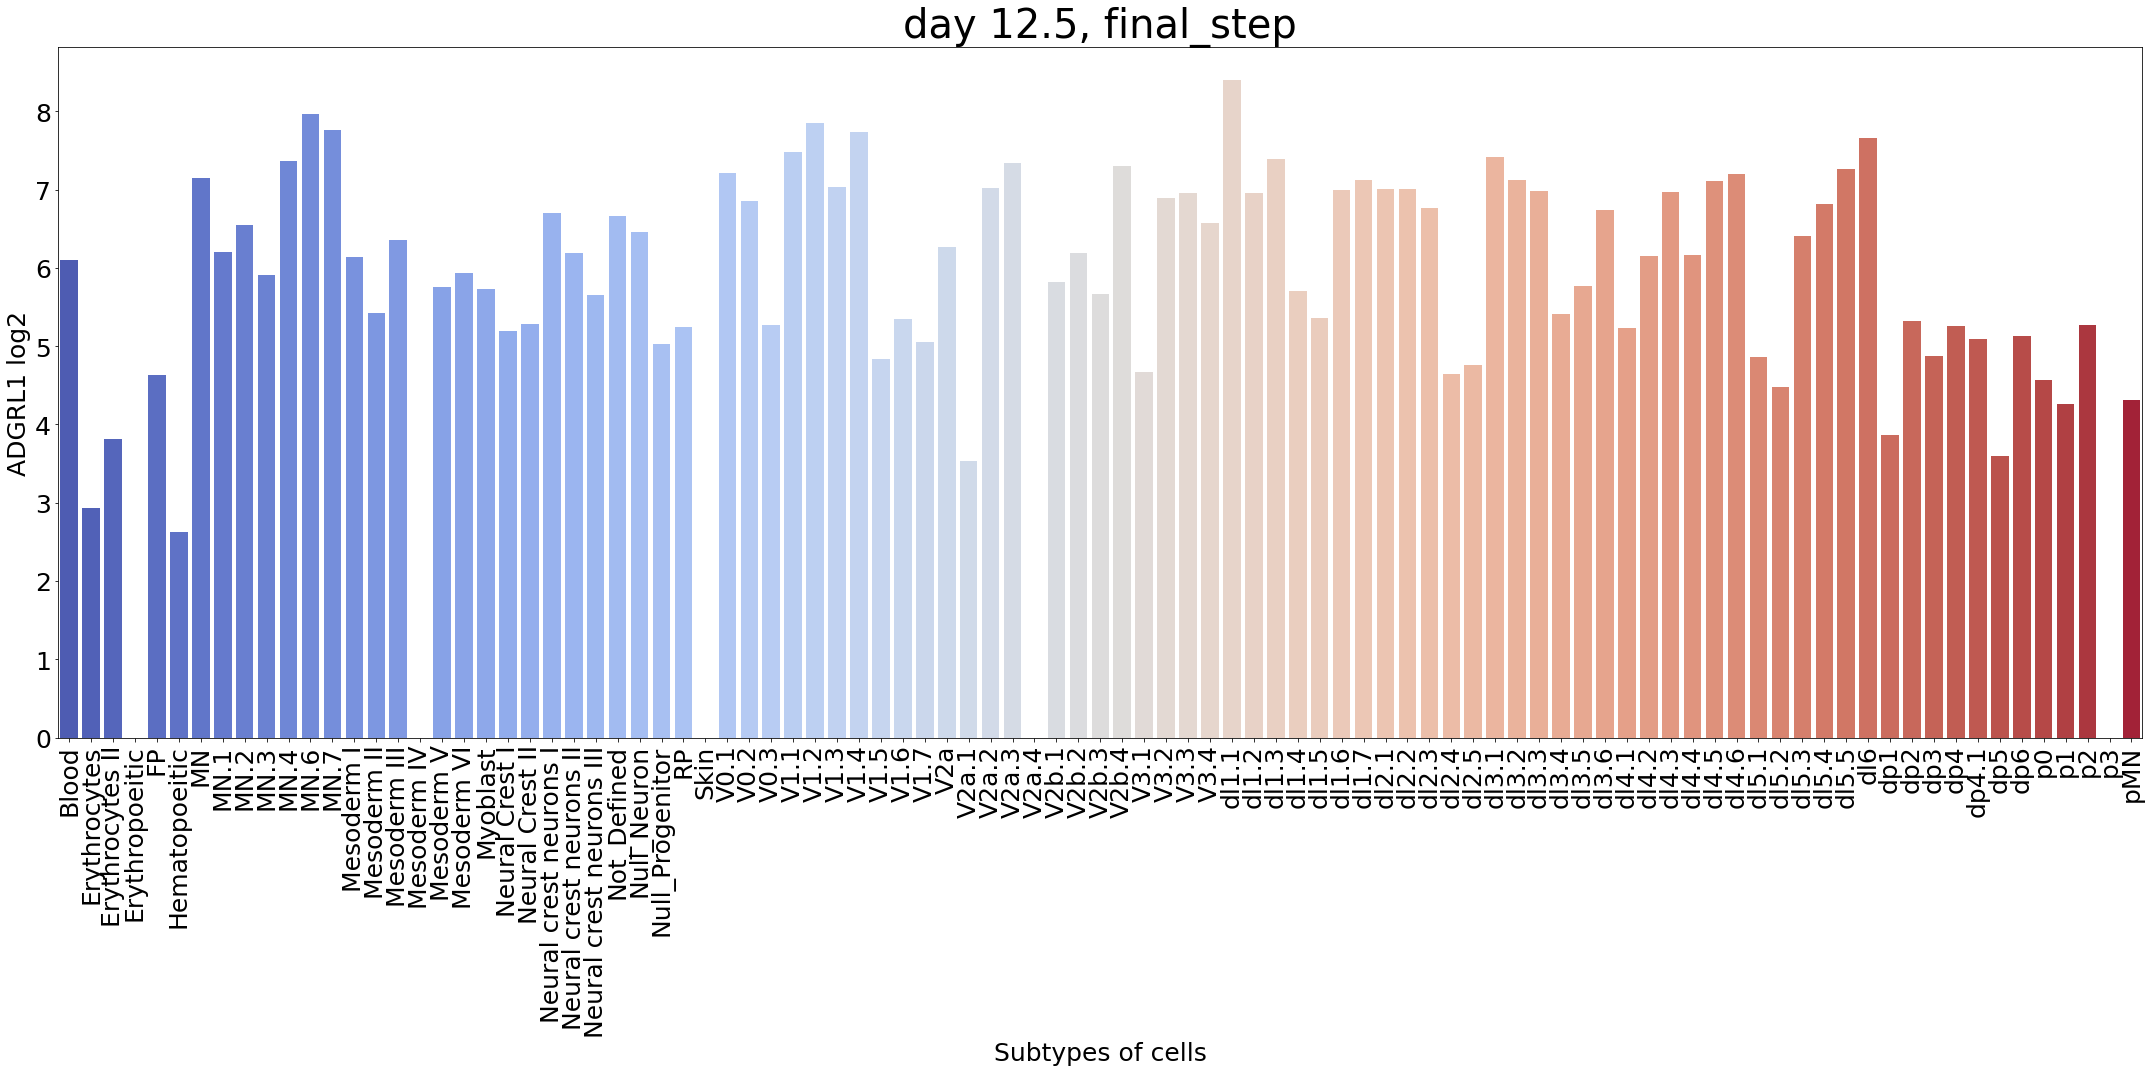

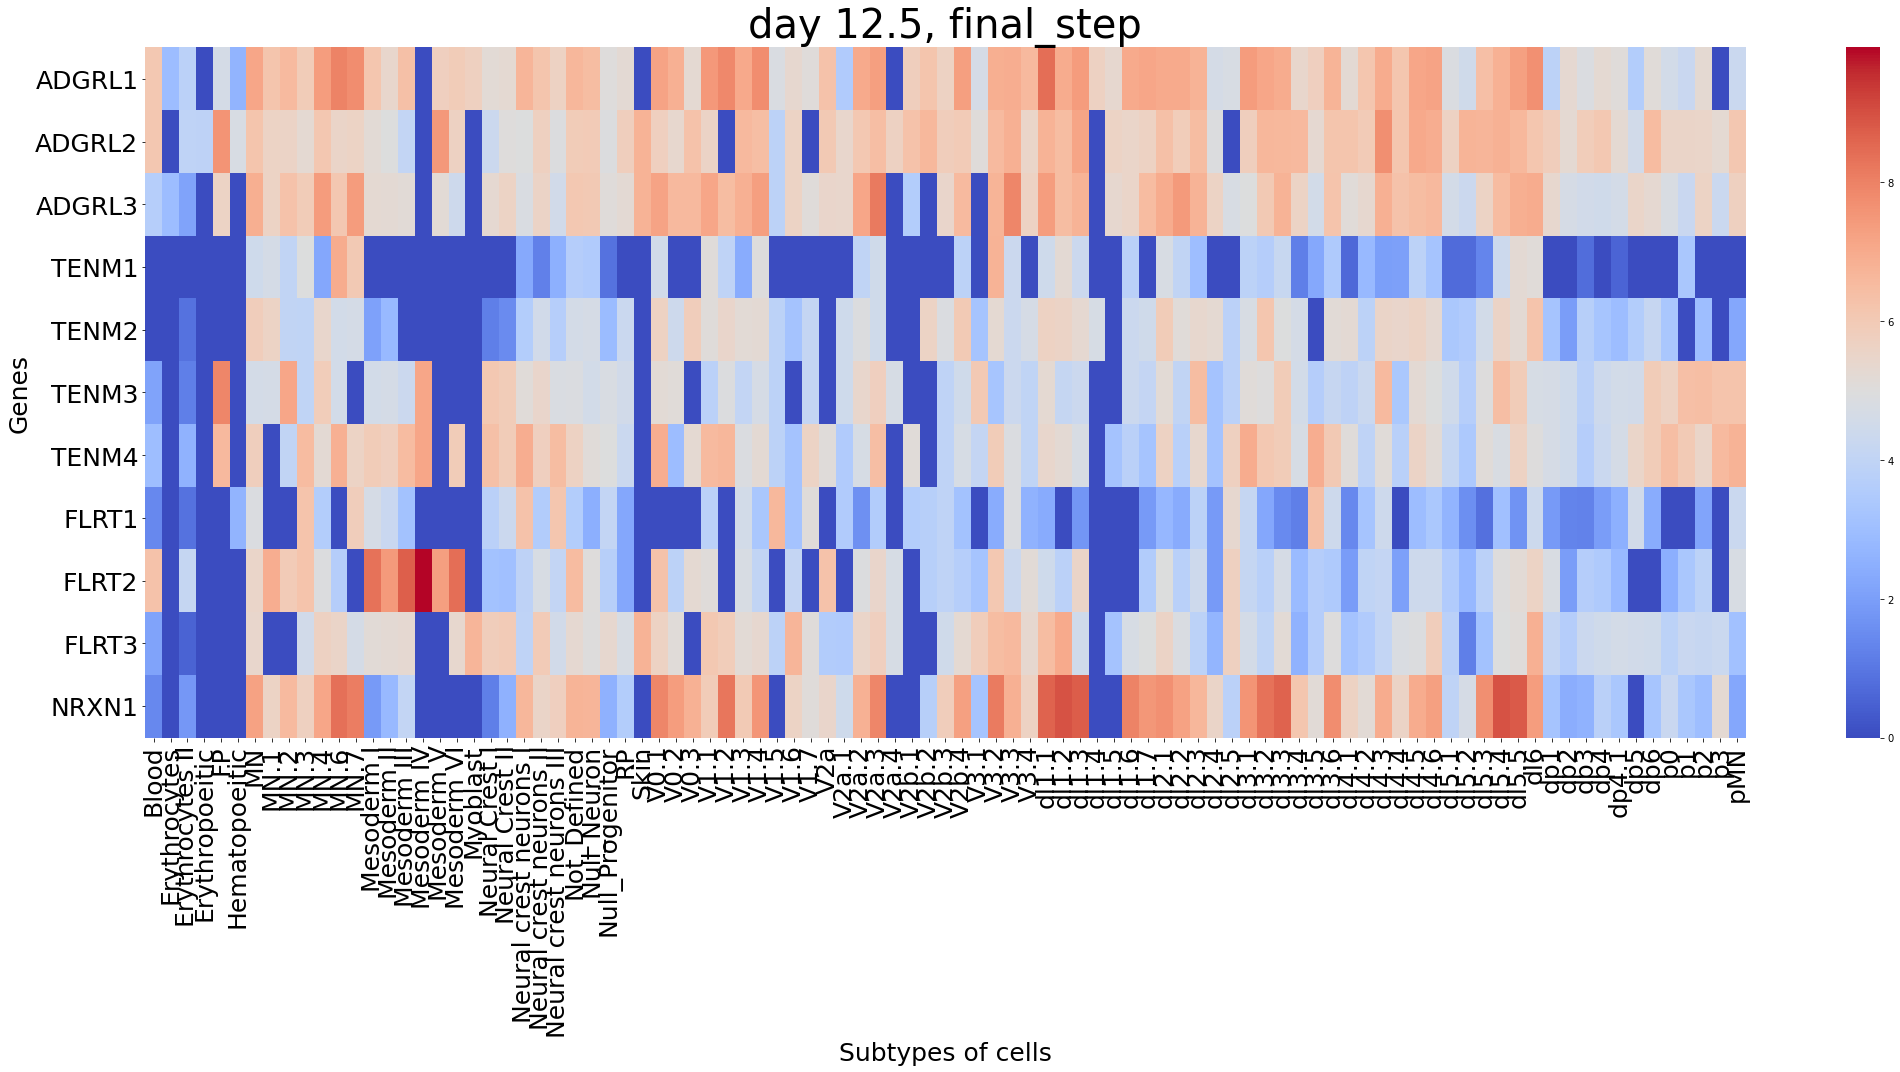

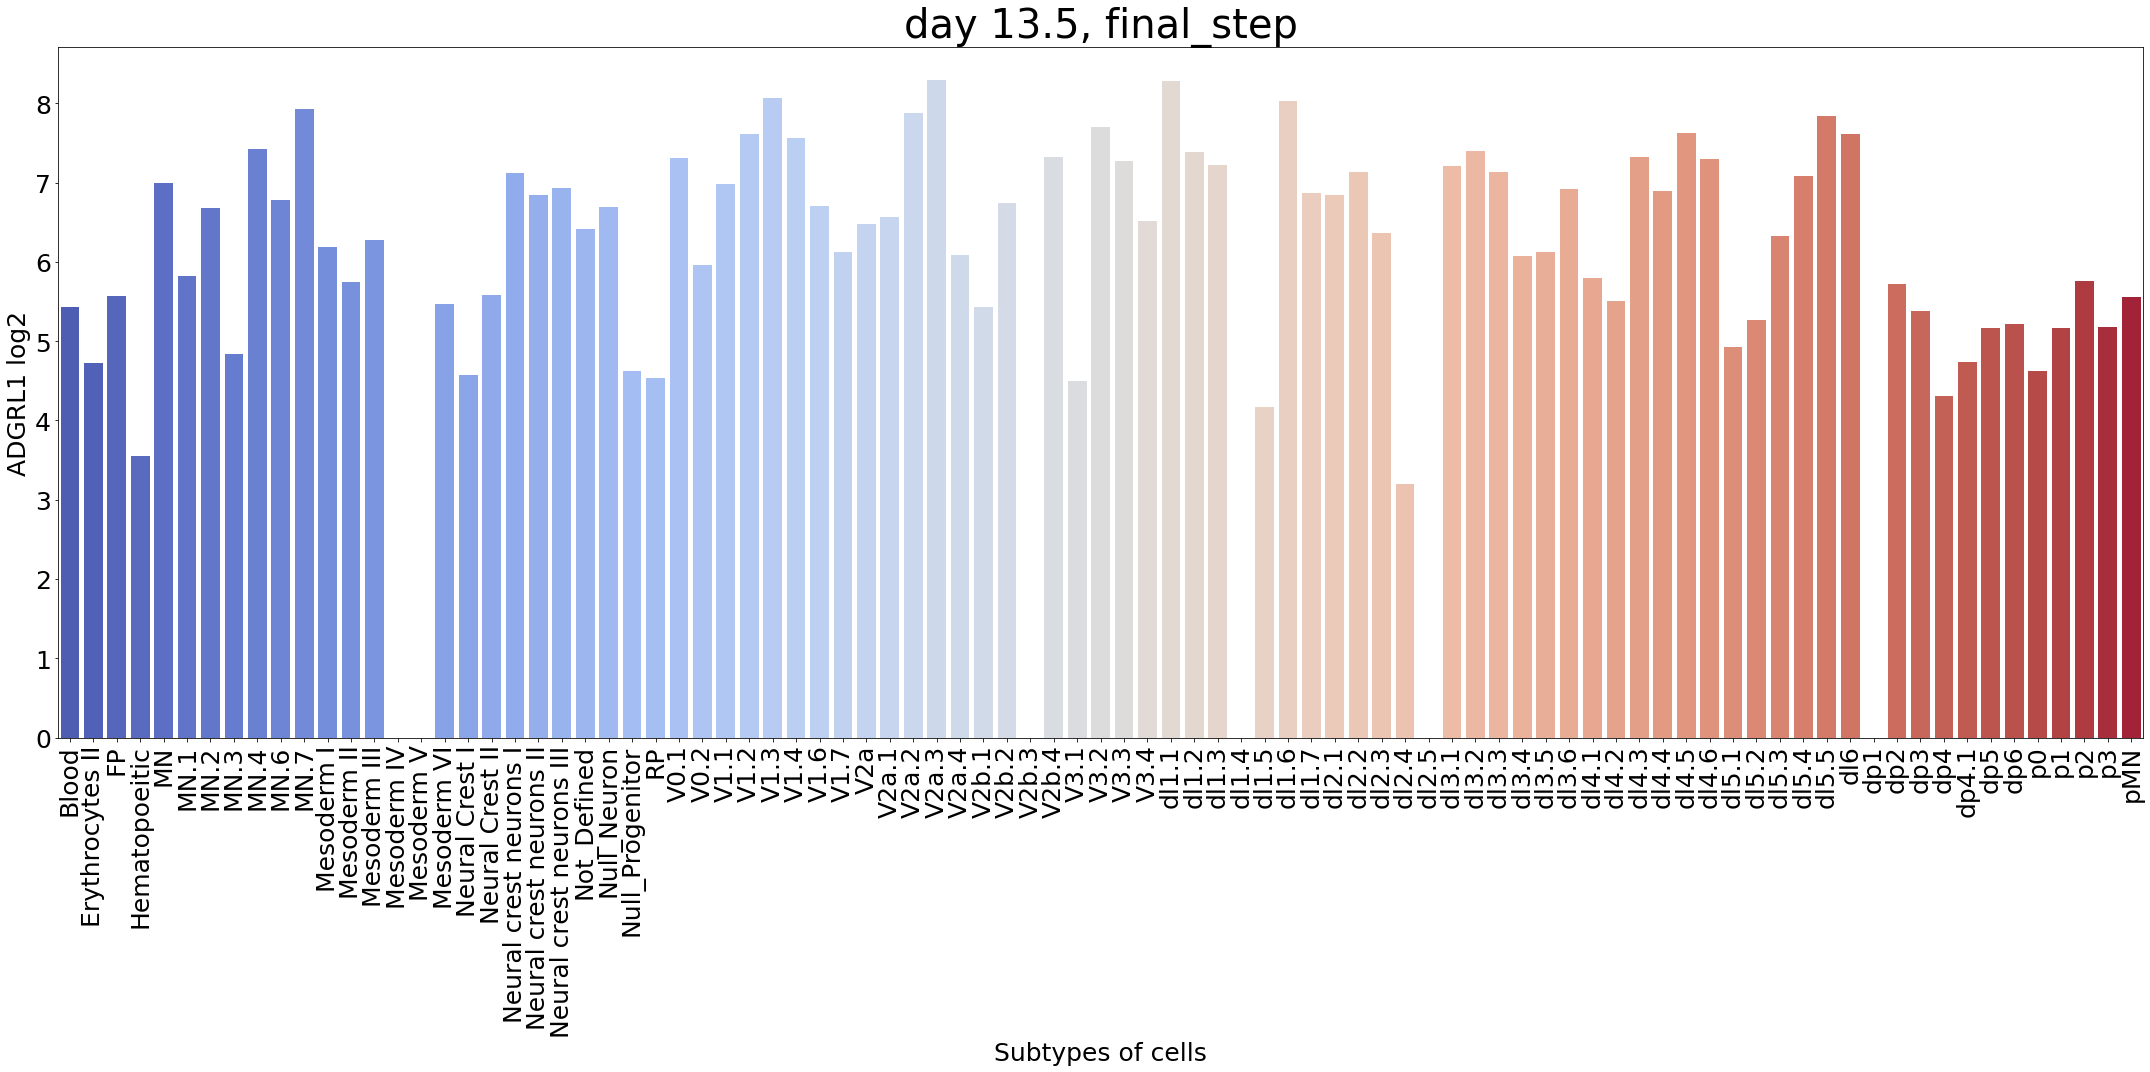

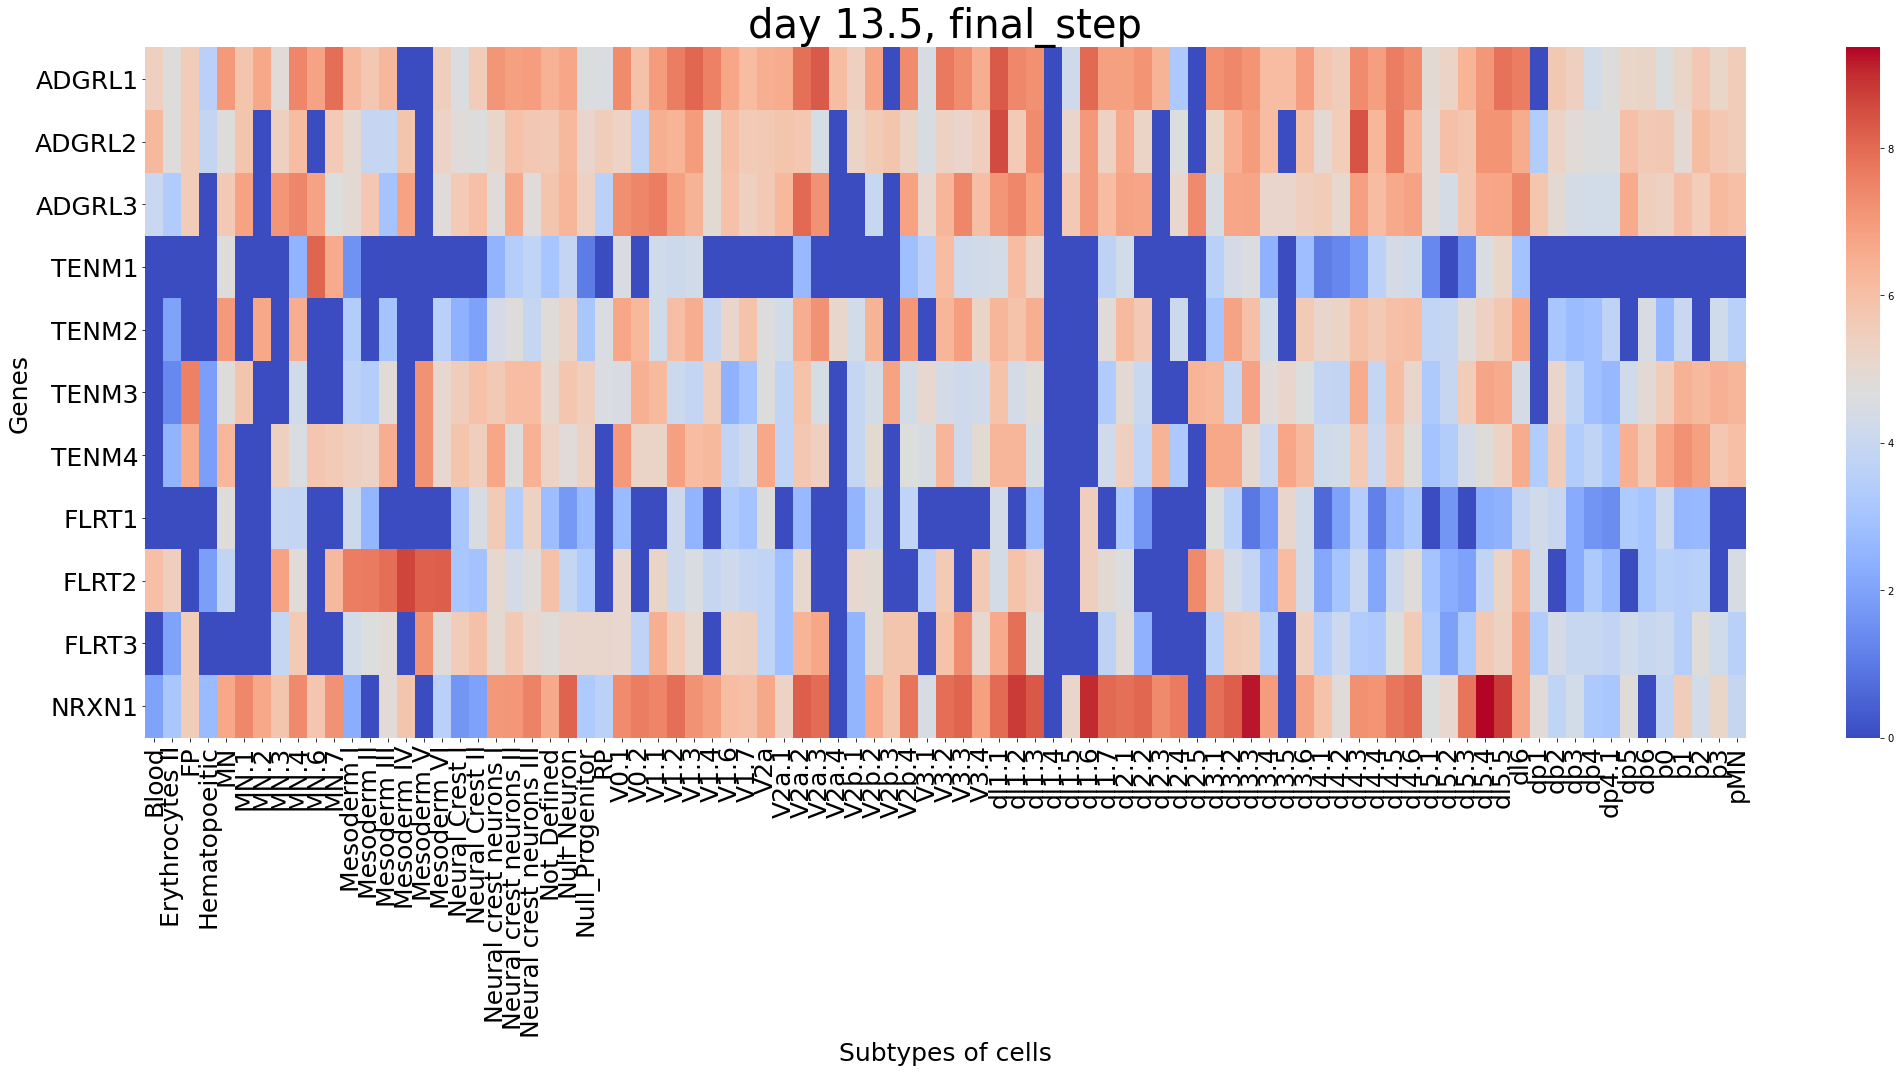

In [53]:
for cols in columns:
    for tp in timepoints:
        data = counts_ts_tp(cols, tp)
        
        barplot(data, tp, cols)
        heatmap(data, tp, cols)
        